# Dataset

In [1]:
import pandas as pd

data = pd.read_csv('iris.csv', header = None)
data

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [2]:
import numpy as np
X = data.iloc[:, 0:4]
Y = data.iloc[:, 4:]
X = np.array(X)

In [3]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).fit(Y)

Y = OHE.transform(Y)

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

class Custom_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X_return = torch.tensor(self.X[idx], dtype = torch.float32)
        Y_return = torch.tensor(self.Y[idx], dtype = torch.float32)
        return X_return, Y_return
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle = True)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size = 0.8, shuffle = True)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)
X_val_scale = scaler.transform(X_val)

train_dataset = Custom_Dataset(X_train_scale, Y_train)
test_dataset = Custom_Dataset(X_test_scale, Y_test)
val_dataset = Custom_Dataset(X_val_scale, Y_val)

batch_size = 50

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)


# Deep Learning Model

In [5]:
import torch.nn as nn

class ANN_Model(nn.Module):
    def __init__(self, n_features, n_targets):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, 50),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(25, 12),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(12, n_targets),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Training

In [6]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
torch.cuda.empty_cache()

def train(model, loss_fn, lr, epochs, train_data, val_data, test_data):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    scaler = torch.cuda.amp.GradScaler()
    lst_loss = []
    lst_accuracy = []
    mean_loss = 0
    mean_accuracy = 0
    lst_mean_loss = []
    lst_mean_accuracy = []
    val_lst_loss = []
    val_lst_accuracy = []
    val_mean_loss = 0
    val_mean_accuracy = 0
    val_lst_mean_loss = []
    val_lst_mean_accuracy = []
    test_lst_loss = []
    test_lst_accuracy = []
    test_mean_loss = 0
    test_mean_accuracy = 0
    test_lst_mean_loss = []
    test_lst_mean_accuracy = []
    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        loop = tqdm(train_data)
        for mb, (x_input, y_output) in enumerate(loop, start = 1):
            model.train()
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.cuda.amp.autocast():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            loop.set_postfix(loss_function = loss.item())
            
        model.eval()
        lst_lost = []
        lst_accuracy = []
        for i, data in enumerate(train_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = torch.argmax(y_output, dim = 1)
                y_output = y_output.cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                lst_accuracy.append(accuracy)
        
        mean_loss = np.mean(lst_loss)
        lst_mean_loss.append(mean_loss)
        mean_accuracy = np.mean(lst_accuracy)
        lst_mean_accuracy.append(mean_accuracy)
        
        val_lst_lost = []
        val_lst_accuracy = []
        for i, data in enumerate(val_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                val_lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = torch.argmax(y_output, dim = 1)
                y_output = y_output.cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                val_lst_accuracy.append(accuracy)
        
        val_mean_loss = np.mean(val_lst_loss)
        val_lst_mean_loss.append(val_mean_loss)
        val_mean_accuracy = np.mean(val_lst_accuracy)
        val_lst_mean_accuracy.append(val_mean_accuracy)
        
        test_lst_lost = []
        test_lst_accuracy = []
        for i, data in enumerate(test_data, 0):
            x_input, y_output = data
            x_input = x_input.to(device = device)
            y_output = y_output.to(device = device)
            with torch.no_grad():
                prediction = model(x_input)
                loss = loss_fn(prediction, y_output)
                test_lst_loss.append(loss.item())
                prediction = torch.argmax(prediction, dim = 1)
                prediction = prediction.cpu().numpy()
                y_output = torch.argmax(y_output, dim = 1)
                y_output = y_output.cpu().numpy()
                accuracy = accuracy_score(y_output, prediction)
                test_lst_accuracy.append(accuracy)
        
        test_mean_loss = np.mean(test_lst_loss)
        test_lst_mean_loss.append(test_mean_loss)
        test_mean_accuracy = np.mean(test_lst_accuracy)
        test_lst_mean_accuracy.append(test_mean_accuracy)

    ax = sns.lineplot(x = range(len(lst_mean_loss)), y = lst_mean_loss, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss)), y = val_lst_mean_loss, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss)), y = test_lst_mean_loss, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    
    ax = sns.lineplot(x = range(len(lst_mean_accuracy)), y = lst_mean_accuracy, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_accuracy)), y = val_lst_mean_accuracy, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_accuracy)), y = test_lst_mean_accuracy, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Train Loss: ", lst_mean_loss[-1])
    print("Validation Loss: ", val_lst_mean_loss[-1])
    print("Test Loss", test_lst_mean_loss[-1])
    print("Train Accuracy: ", lst_mean_accuracy[-1])
    print("Validation Accuracy: ", val_lst_mean_accuracy[-1])
    print("Test Accuracy", test_lst_mean_accuracy[-1])
    
    
    return model, lst_mean_loss[-1], val_lst_mean_loss[-1], test_lst_mean_loss[-1], lst_mean_accuracy[-1], val_lst_mean_accuracy[-1], test_lst_mean_accuracy[-1]

Epoch:  1


100%|████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s, loss_function=1.12]


Epoch:  2


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 153.67it/s, loss_function=1.08]


Epoch:  3


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.30it/s, loss_function=1.1]


Epoch:  4


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.15it/s, loss_function=1.1]


Epoch:  5


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.85it/s, loss_function=1.1]


Epoch:  6


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.40it/s, loss_function=1.11]


Epoch:  7


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.88it/s, loss_function=1.09]


Epoch:  8


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.97it/s, loss_function=1.09]


Epoch:  9


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 146.25it/s, loss_function=1.1]


Epoch:  10


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.45it/s, loss_function=1.12]


Epoch:  11


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.99it/s, loss_function=1.08]


Epoch:  12


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.89it/s, loss_function=1.1]


Epoch:  13


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.64it/s, loss_function=1.1]

Epoch:  14



100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.48it/s, loss_function=1.1]


Epoch:  15


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.67it/s, loss_function=1.1]

Epoch:  16



100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.01it/s, loss_function=1.1]


Epoch:  17


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.69it/s, loss_function=1.11]


Epoch:  18


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.87it/s, loss_function=1.08]


Epoch:  19


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.24it/s, loss_function=1.09]


Epoch:  20


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.48it/s, loss_function=1.08]


Epoch:  21


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.89it/s, loss_function=1.1]

Epoch:  22



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 153.72it/s, loss_function=1.07]


Epoch:  23


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.92it/s, loss_function=1.09]


Epoch:  24


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.42it/s, loss_function=1.11]


Epoch:  25


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.46it/s, loss_function=1.1]


Epoch:  26


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.88it/s, loss_function=1.09]


Epoch:  27


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.89it/s, loss_function=1.09]


Epoch:  28


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.46it/s, loss_function=1.07]


Epoch:  29


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.68it/s, loss_function=1.11]


Epoch:  30


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.66it/s, loss_function=1.09]


Epoch:  31


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.82it/s, loss_function=1.11]


Epoch:  32


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.41it/s, loss_function=1.07]


Epoch:  33


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.37it/s, loss_function=1.11]


Epoch:  34


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.96it/s, loss_function=1.07]


Epoch:  35


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.51it/s, loss_function=1.09]


Epoch:  36


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 130.41it/s, loss_function=1.07]

Epoch:  37



100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.65it/s, loss_function=1.1]


Epoch:  38


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.70it/s, loss_function=1.09]


Epoch:  39


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.64it/s, loss_function=1.07]


Epoch:  40


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.00it/s, loss_function=1.09]

Epoch:  41



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.73it/s, loss_function=1.08]


Epoch:  42


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.30it/s, loss_function=1.1]


Epoch:  43


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.10it/s, loss_function=1.09]


Epoch:  44


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.63it/s, loss_function=1.1]


Epoch:  45


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.78it/s, loss_function=1.08]


Epoch:  46


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.73it/s, loss_function=1.05]


Epoch:  47


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.03it/s, loss_function=1.08]


Epoch:  48


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.60it/s, loss_function=1.1]


Epoch:  49


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.86it/s, loss_function=1.07]


Epoch:  50


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.39it/s, loss_function=1.08]


Epoch:  51


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.18it/s, loss_function=1.09]

Epoch:  52



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.36it/s, loss_function=1.09]

Epoch:  53



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.98it/s, loss_function=1.08]


Epoch:  54


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.04it/s, loss_function=1.08]

Epoch:  55



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.81it/s, loss_function=1.08]


Epoch:  56


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.74it/s, loss_function=1.08]


Epoch:  57


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.26it/s, loss_function=1.08]


Epoch:  58


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.20it/s, loss_function=1.09]


Epoch:  59


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.32it/s, loss_function=1.07]


Epoch:  60


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.64it/s, loss_function=1.1]


Epoch:  61


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.60it/s, loss_function=1.08]


Epoch:  62


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.99it/s, loss_function=1.06]


Epoch:  63


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.93it/s, loss_function=1.08]


Epoch:  64


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.52it/s, loss_function=1.08]


Epoch:  65


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.96it/s, loss_function=1.09]


Epoch:  66


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.93it/s, loss_function=1.11]


Epoch:  67


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.69it/s, loss_function=1.04]


Epoch:  68


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.21it/s, loss_function=1.08]


Epoch:  69


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.38it/s, loss_function=1.09]

Epoch:  70



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.11it/s, loss_function=1.08]


Epoch:  71


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.89it/s, loss_function=1.07]


Epoch:  72


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.49it/s, loss_function=1.05]

Epoch:  73



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.85it/s, loss_function=1.06]


Epoch:  74


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.61it/s, loss_function=1.07]


Epoch:  75


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.94it/s, loss_function=1.05]


Epoch:  76


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.53it/s, loss_function=1.07]


Epoch:  77


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.61it/s, loss_function=1.07]


Epoch:  78


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.50it/s, loss_function=1.07]


Epoch:  79


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.26it/s, loss_function=1.07]


Epoch:  80


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.17it/s, loss_function=1.04]


Epoch:  81


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.30it/s, loss_function=1.11]


Epoch:  82


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.53it/s, loss_function=1.03]


Epoch:  83


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.39it/s, loss_function=1.07]


Epoch:  84


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.94it/s, loss_function=1.09]


Epoch:  85


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.78it/s, loss_function=1.06]


Epoch:  86


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.61it/s, loss_function=1.09]


Epoch:  87


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.75it/s, loss_function=1.04]


Epoch:  88


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.69it/s, loss_function=1.04]


Epoch:  89


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.39it/s, loss_function=1.06]


Epoch:  90


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.74it/s, loss_function=1.08]


Epoch:  91


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.47it/s, loss_function=1.03]


Epoch:  92


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.49it/s, loss_function=1.02]


Epoch:  93


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.94it/s, loss_function=1.03]


Epoch:  94


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.81it/s, loss_function=1.05]


Epoch:  95


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.65it/s, loss_function=1.03]


Epoch:  96


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.26it/s, loss_function=1.05]


Epoch:  97


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.78it/s, loss_function=1.01]


Epoch:  98


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.60it/s, loss_function=1.04]


Epoch:  99


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.07it/s, loss_function=1.04]

Epoch:  100



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.91it/s, loss_function=1.05]


Epoch:  101


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.28it/s, loss_function=1.06]


Epoch:  102


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 250.86it/s, loss_function=1.04]


Epoch:  103


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.89it/s, loss_function=1.03]


Epoch:  104


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.39it/s, loss_function=1.04]


Epoch:  105


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.72it/s, loss_function=0.986]


Epoch:  106


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.70it/s, loss_function=1.04]


Epoch:  107


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.21it/s, loss_function=1.03]


Epoch:  108


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.50it/s, loss_function=0.996]


Epoch:  109


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.96it/s, loss_function=1.02]


Epoch:  110


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.32it/s, loss_function=1.05]


Epoch:  111


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.77it/s, loss_function=0.994]


Epoch:  112


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.09it/s, loss_function=1.05]


Epoch:  113


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.81it/s, loss_function=0.995]


Epoch:  114


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.43it/s, loss_function=1.02]


Epoch:  115


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.14it/s, loss_function=0.993]


Epoch:  116


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.55it/s, loss_function=1.05]


Epoch:  117


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.34it/s, loss_function=1.01]

Epoch:  118



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.40it/s, loss_function=0.999]


Epoch:  119


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.78it/s, loss_function=1.02]


Epoch:  120


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.01it/s, loss_function=1.03]


Epoch:  121


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.46it/s, loss_function=0.996]


Epoch:  122


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 289.79it/s, loss_function=1.02]


Epoch:  123


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.81it/s, loss_function=0.974]


Epoch:  124


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.00it/s, loss_function=1.03]


Epoch:  125


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.36it/s, loss_function=0.975]


Epoch:  126


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.56it/s, loss_function=1.02]


Epoch:  127


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.58it/s, loss_function=0.987]


Epoch:  128


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.17it/s, loss_function=0.99]


Epoch:  129


100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 302.90it/s, loss_function=1]


Epoch:  130


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.97it/s, loss_function=0.994]


Epoch:  131


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.98it/s, loss_function=0.945]


Epoch:  132


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 245.61it/s, loss_function=1.01]


Epoch:  133


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.93it/s, loss_function=0.982]


Epoch:  134


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.10it/s, loss_function=1.01]


Epoch:  135


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.45it/s, loss_function=0.95]


Epoch:  136


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 265.17it/s, loss_function=0.949]


Epoch:  137


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.84it/s, loss_function=1.05]


Epoch:  138


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.59it/s, loss_function=0.961]


Epoch:  139


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.93it/s, loss_function=1.02]


Epoch:  140


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.78it/s, loss_function=0.961]


Epoch:  141


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.61it/s, loss_function=0.96]


Epoch:  142


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.17it/s, loss_function=1.02]


Epoch:  143


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.88it/s, loss_function=1.01]


Epoch:  144


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.89it/s, loss_function=0.965]


Epoch:  145


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.39it/s, loss_function=1.02]


Epoch:  146


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.61it/s, loss_function=1.02]


Epoch:  147


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.79it/s, loss_function=0.944]


Epoch:  148


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 313.94it/s, loss_function=1.04]


Epoch:  149


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.56it/s, loss_function=0.96]


Epoch:  150


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.87it/s, loss_function=0.985]


Epoch:  151


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.21it/s, loss_function=1.01]


Epoch:  152


100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.10it/s, loss_function=1]


Epoch:  153


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.56it/s, loss_function=0.969]


Epoch:  154


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.44it/s, loss_function=0.998]


Epoch:  155


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.95it/s, loss_function=0.973]


Epoch:  156


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.95it/s, loss_function=0.954]


Epoch:  157


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.22it/s, loss_function=0.944]

Epoch:  158



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.20it/s, loss_function=0.995]


Epoch:  159


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 268.66it/s, loss_function=0.984]


Epoch:  160


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.80it/s, loss_function=0.974]


Epoch:  161


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.12it/s, loss_function=0.947]


Epoch:  162


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.38it/s, loss_function=0.945]


Epoch:  163


100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.75it/s, loss_function=1]


Epoch:  164


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.45it/s, loss_function=0.948]


Epoch:  165


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.21it/s, loss_function=0.949]


Epoch:  166


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.62it/s, loss_function=0.963]


Epoch:  167


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.18it/s, loss_function=0.988]

Epoch:  168



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.25it/s, loss_function=0.884]


Epoch:  169


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.92it/s, loss_function=0.936]


Epoch:  170


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.85it/s, loss_function=0.925]


Epoch:  171


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.18it/s, loss_function=0.981]


Epoch:  172


100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.37it/s, loss_function=1]


Epoch:  173


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.93it/s, loss_function=0.937]


Epoch:  174


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.25it/s, loss_function=0.871]


Epoch:  175


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.94it/s, loss_function=0.933]


Epoch:  176


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.64it/s, loss_function=1.02]


Epoch:  177


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.11it/s, loss_function=0.893]


Epoch:  178


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.44it/s, loss_function=0.954]


Epoch:  179


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.75it/s, loss_function=0.926]


Epoch:  180


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.15it/s, loss_function=0.941]


Epoch:  181


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.56it/s, loss_function=0.973]


Epoch:  182


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.41it/s, loss_function=0.993]

Epoch:  183



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.94it/s, loss_function=0.869]


Epoch:  184


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.60it/s, loss_function=0.909]


Epoch:  185


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.38it/s, loss_function=0.975]


Epoch:  186


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.40it/s, loss_function=0.866]


Epoch:  187


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 88.58it/s, loss_function=0.931]


Epoch:  188


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.12it/s, loss_function=1.01]


Epoch:  189


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.55it/s, loss_function=0.887]


Epoch:  190


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.20it/s, loss_function=0.941]


Epoch:  191


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 282.13it/s, loss_function=1.01]


Epoch:  192


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.95it/s, loss_function=0.938]


Epoch:  193


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 305.09it/s, loss_function=0.829]


Epoch:  194


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.22it/s, loss_function=0.924]


Epoch:  195


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.52it/s, loss_function=0.87]


Epoch:  196


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.64it/s, loss_function=0.942]


Epoch:  197


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.58it/s, loss_function=0.9]


Epoch:  198


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.18it/s, loss_function=0.879]


Epoch:  199


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.81it/s, loss_function=0.909]


Epoch:  200


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.55it/s, loss_function=0.914]


Epoch:  201


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.98it/s, loss_function=0.885]


Epoch:  202


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.53it/s, loss_function=0.95]


Epoch:  203


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.83it/s, loss_function=0.957]


Epoch:  204


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.43it/s, loss_function=0.885]

Epoch:  205



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.28it/s, loss_function=0.918]


Epoch:  206


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.53it/s, loss_function=0.894]


Epoch:  207


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.72it/s, loss_function=0.927]


Epoch:  208


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 263.30it/s, loss_function=0.867]


Epoch:  209


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.17it/s, loss_function=0.918]


Epoch:  210


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.17it/s, loss_function=0.974]


Epoch:  211


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.90it/s, loss_function=0.906]


Epoch:  212


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.78it/s, loss_function=0.955]

Epoch:  213



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.02it/s, loss_function=0.939]


Epoch:  214


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.81it/s, loss_function=0.924]


Epoch:  215


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.68it/s, loss_function=0.883]


Epoch:  216


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 280.58it/s, loss_function=0.848]


Epoch:  217


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.78it/s, loss_function=0.903]


Epoch:  218


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.50it/s, loss_function=0.916]


Epoch:  219


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.27it/s, loss_function=0.924]


Epoch:  220


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.83it/s, loss_function=0.938]


Epoch:  221


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.27it/s, loss_function=0.965]


Epoch:  222


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.91it/s, loss_function=0.91]


Epoch:  223


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.02it/s, loss_function=0.976]

Epoch:  224



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.56it/s, loss_function=0.886]


Epoch:  225


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.70it/s, loss_function=0.905]


Epoch:  226


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.45it/s, loss_function=0.943]

Epoch:  227



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.97it/s, loss_function=0.886]


Epoch:  228


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.09it/s, loss_function=0.864]


Epoch:  229


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.56it/s, loss_function=0.912]


Epoch:  230


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.57it/s, loss_function=0.921]


Epoch:  231


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.73it/s, loss_function=0.915]


Epoch:  232


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.21it/s, loss_function=0.884]


Epoch:  233


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.06it/s, loss_function=0.875]


Epoch:  234


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.10it/s, loss_function=0.863]


Epoch:  235


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.93it/s, loss_function=0.98]


Epoch:  236


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.83it/s, loss_function=0.934]


Epoch:  237


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.96it/s, loss_function=0.892]


Epoch:  238


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.68it/s, loss_function=0.928]


Epoch:  239


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.94it/s, loss_function=0.823]


Epoch:  240


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.57it/s, loss_function=0.857]


Epoch:  241


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.78it/s, loss_function=0.901]


Epoch:  242


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.03it/s, loss_function=0.898]


Epoch:  243


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.78it/s, loss_function=0.923]


Epoch:  244


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.39it/s, loss_function=0.833]


Epoch:  245


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.11it/s, loss_function=0.899]


Epoch:  246


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.59it/s, loss_function=0.87]


Epoch:  247


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.68it/s, loss_function=0.901]


Epoch:  248


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.85it/s, loss_function=0.832]


Epoch:  249


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.51it/s, loss_function=0.869]


Epoch:  250


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.54it/s, loss_function=0.887]

Epoch:  251



100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.17it/s, loss_function=0.9]

Epoch:  252



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.38it/s, loss_function=0.849]


Epoch:  253


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.56it/s, loss_function=0.92]

Epoch:  254



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.68it/s, loss_function=0.906]


Epoch:  255


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.18it/s, loss_function=0.795]


Epoch:  256


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 234.07it/s, loss_function=0.82]


Epoch:  257


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.75it/s, loss_function=0.869]


Epoch:  258


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.98it/s, loss_function=0.855]


Epoch:  259


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.09it/s, loss_function=0.897]


Epoch:  260


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.11it/s, loss_function=0.865]


Epoch:  261


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.46it/s, loss_function=0.885]


Epoch:  262


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.44it/s, loss_function=0.839]


Epoch:  263


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.57it/s, loss_function=0.847]


Epoch:  264


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 308.70it/s, loss_function=0.873]


Epoch:  265


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.12it/s, loss_function=0.855]


Epoch:  266


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.57it/s, loss_function=0.81]


Epoch:  267


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.63it/s, loss_function=0.8]


Epoch:  268


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.64it/s, loss_function=0.844]


Epoch:  269


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.38it/s, loss_function=0.887]


Epoch:  270


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.00it/s, loss_function=0.845]


Epoch:  271


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.03it/s, loss_function=0.879]


Epoch:  272


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 312.21it/s, loss_function=0.853]


Epoch:  273


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.12it/s, loss_function=0.817]


Epoch:  274


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.20it/s, loss_function=0.861]


Epoch:  275


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.43it/s, loss_function=0.885]


Epoch:  276


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.43it/s, loss_function=0.827]


Epoch:  277


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.93it/s, loss_function=0.858]


Epoch:  278


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.51it/s, loss_function=0.832]


Epoch:  279


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.89it/s, loss_function=0.783]


Epoch:  280


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 278.78it/s, loss_function=0.838]


Epoch:  281


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.29it/s, loss_function=0.852]


Epoch:  282


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.57it/s, loss_function=0.85]


Epoch:  283


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.17it/s, loss_function=0.834]


Epoch:  284


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.82it/s, loss_function=0.706]


Epoch:  285


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.67it/s, loss_function=0.852]

Epoch:  286



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.65it/s, loss_function=0.833]


Epoch:  287


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.71it/s, loss_function=0.754]


Epoch:  288


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.29it/s, loss_function=0.856]


Epoch:  289


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.56it/s, loss_function=0.925]


Epoch:  290


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 264.53it/s, loss_function=0.932]


Epoch:  291


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 154.03it/s, loss_function=0.859]

Epoch:  292



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.44it/s, loss_function=0.85]


Epoch:  293


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.38it/s, loss_function=0.809]

Epoch:  294



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.65it/s, loss_function=0.817]


Epoch:  295


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.65it/s, loss_function=0.802]


Epoch:  296


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.48it/s, loss_function=0.813]


Epoch:  297


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.96it/s, loss_function=0.765]


Epoch:  298


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.84it/s, loss_function=0.803]


Epoch:  299


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.18it/s, loss_function=0.805]


Epoch:  300


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.74it/s, loss_function=0.873]


Epoch:  301


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.00it/s, loss_function=0.896]


Epoch:  302


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.16it/s, loss_function=0.855]


Epoch:  303


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 130.48it/s, loss_function=0.779]


Epoch:  304


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.18it/s, loss_function=0.796]


Epoch:  305


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 269.68it/s, loss_function=0.833]


Epoch:  306


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.44it/s, loss_function=0.83]


Epoch:  307


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.85it/s, loss_function=0.865]


Epoch:  308


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.54it/s, loss_function=0.817]


Epoch:  309


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.34it/s, loss_function=0.769]


Epoch:  310


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.42it/s, loss_function=0.752]


Epoch:  311


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.62it/s, loss_function=0.714]


Epoch:  312


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.82it/s, loss_function=0.811]


Epoch:  313


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.68it/s, loss_function=0.847]


Epoch:  314


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.88it/s, loss_function=0.841]

Epoch:  315



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.44it/s, loss_function=0.788]


Epoch:  316


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.73it/s, loss_function=0.794]


Epoch:  317


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.06it/s, loss_function=0.773]


Epoch:  318


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.11it/s, loss_function=0.812]


Epoch:  319


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.72it/s, loss_function=0.814]


Epoch:  320


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.59it/s, loss_function=0.861]


Epoch:  321


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.81it/s, loss_function=0.777]


Epoch:  322


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.60it/s, loss_function=0.756]


Epoch:  323


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.70it/s, loss_function=0.87]


Epoch:  324


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.61it/s, loss_function=0.853]


Epoch:  325


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.80it/s, loss_function=0.804]


Epoch:  326


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.11it/s, loss_function=0.776]

Epoch:  327



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.90it/s, loss_function=0.767]


Epoch:  328


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.81it/s, loss_function=0.853]


Epoch:  329


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 254.63it/s, loss_function=0.785]


Epoch:  330


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 282.64it/s, loss_function=0.786]


Epoch:  331


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.95it/s, loss_function=0.76]


Epoch:  332


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.96it/s, loss_function=0.723]


Epoch:  333


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.92it/s, loss_function=0.787]


Epoch:  334


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.25it/s, loss_function=0.843]

Epoch:  335



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.01it/s, loss_function=0.826]


Epoch:  336


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.80it/s, loss_function=0.779]


Epoch:  337


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.47it/s, loss_function=0.75]


Epoch:  338


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.62it/s, loss_function=0.757]


Epoch:  339


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.07it/s, loss_function=0.815]


Epoch:  340


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.62it/s, loss_function=0.743]


Epoch:  341


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.98it/s, loss_function=0.823]


Epoch:  342


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.75it/s, loss_function=0.78]


Epoch:  343


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.60it/s, loss_function=0.786]


Epoch:  344


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.66it/s, loss_function=0.783]


Epoch:  345


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.79it/s, loss_function=0.744]


Epoch:  346


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.64it/s, loss_function=0.805]


Epoch:  347


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 276.38it/s, loss_function=0.711]


Epoch:  348


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.33it/s, loss_function=0.765]


Epoch:  349


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.16it/s, loss_function=0.813]


Epoch:  350


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.12it/s, loss_function=0.829]


Epoch:  351


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.82it/s, loss_function=0.771]


Epoch:  352


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.11it/s, loss_function=0.768]


Epoch:  353


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.43it/s, loss_function=0.811]

Epoch:  354



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.49it/s, loss_function=0.794]


Epoch:  355


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.44it/s, loss_function=0.789]


Epoch:  356


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.83it/s, loss_function=0.805]


Epoch:  357


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.41it/s, loss_function=0.77]


Epoch:  358


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.37it/s, loss_function=0.789]


Epoch:  359


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.97it/s, loss_function=0.826]


Epoch:  360


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.56it/s, loss_function=0.72]


Epoch:  361


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.68it/s, loss_function=0.736]


Epoch:  362


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.60it/s, loss_function=0.777]


Epoch:  363


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.82it/s, loss_function=0.754]


Epoch:  364


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.27it/s, loss_function=0.836]


Epoch:  365


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.61it/s, loss_function=0.769]


Epoch:  366


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 263.84it/s, loss_function=0.715]


Epoch:  367


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.37it/s, loss_function=0.836]


Epoch:  368


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.59it/s, loss_function=0.78]


Epoch:  369


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.17it/s, loss_function=0.72]

Epoch:  370



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.66it/s, loss_function=0.713]


Epoch:  371


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.62it/s, loss_function=0.764]


Epoch:  372


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.14it/s, loss_function=0.779]

Epoch:  373



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.05it/s, loss_function=0.742]


Epoch:  374


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.51it/s, loss_function=0.75]

Epoch:  375



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.60it/s, loss_function=0.733]

Epoch:  376



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.07it/s, loss_function=0.784]


Epoch:  377


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.92it/s, loss_function=0.77]


Epoch:  378


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.42it/s, loss_function=0.778]


Epoch:  379


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.03it/s, loss_function=0.69]


Epoch:  380


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 278.18it/s, loss_function=0.818]


Epoch:  381


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.78it/s, loss_function=0.755]


Epoch:  382


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.42it/s, loss_function=0.75]


Epoch:  383


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 264.57it/s, loss_function=0.704]

Epoch:  384



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.56it/s, loss_function=0.745]


Epoch:  385


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.01it/s, loss_function=0.676]


Epoch:  386


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.00it/s, loss_function=0.769]


Epoch:  387


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 254.35it/s, loss_function=0.802]


Epoch:  388


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.57it/s, loss_function=0.746]


Epoch:  389


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.57it/s, loss_function=0.776]


Epoch:  390


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.27it/s, loss_function=0.71]


Epoch:  391


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.57it/s, loss_function=0.732]


Epoch:  392


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.04it/s, loss_function=0.737]


Epoch:  393


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.88it/s, loss_function=0.739]


Epoch:  394


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.38it/s, loss_function=0.771]


Epoch:  395


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.08it/s, loss_function=0.768]

Epoch:  396



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.86it/s, loss_function=0.803]


Epoch:  397


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.39it/s, loss_function=0.734]


Epoch:  398


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.66it/s, loss_function=0.703]


Epoch:  399


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.03it/s, loss_function=0.755]


Epoch:  400


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.41it/s, loss_function=0.748]

Epoch:  401



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.25it/s, loss_function=0.716]

Epoch:  402



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.59it/s, loss_function=0.773]


Epoch:  403


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.75it/s, loss_function=0.743]


Epoch:  404


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.69it/s, loss_function=0.695]


Epoch:  405


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.45it/s, loss_function=0.706]


Epoch:  406


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.86it/s, loss_function=0.753]


Epoch:  407


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.59it/s, loss_function=0.718]


Epoch:  408


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 262.34it/s, loss_function=0.696]


Epoch:  409


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.66it/s, loss_function=0.683]


Epoch:  410


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.22it/s, loss_function=0.672]


Epoch:  411


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.50it/s, loss_function=0.706]


Epoch:  412


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.15it/s, loss_function=0.77]


Epoch:  413


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.85it/s, loss_function=0.781]


Epoch:  414


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.75it/s, loss_function=0.74]


Epoch:  415


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.40it/s, loss_function=0.719]


Epoch:  416


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.01it/s, loss_function=0.804]

Epoch:  417



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.52it/s, loss_function=0.798]


Epoch:  418


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.93it/s, loss_function=0.742]

Epoch:  419



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.80it/s, loss_function=0.707]

Epoch:  420



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.47it/s, loss_function=0.73]


Epoch:  421


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.16it/s, loss_function=0.712]


Epoch:  422


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.01it/s, loss_function=0.764]

Epoch:  423



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.58it/s, loss_function=0.751]


Epoch:  424


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.67it/s, loss_function=0.705]


Epoch:  425


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.40it/s, loss_function=0.805]


Epoch:  426


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.49it/s, loss_function=0.723]


Epoch:  427


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.91it/s, loss_function=0.737]


Epoch:  428


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.38it/s, loss_function=0.74]


Epoch:  429


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 155.39it/s, loss_function=0.729]


Epoch:  430


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.28it/s, loss_function=0.642]


Epoch:  431


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.92it/s, loss_function=0.669]


Epoch:  432


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.53it/s, loss_function=0.789]

Epoch:  433



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.13it/s, loss_function=0.703]


Epoch:  434


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.23it/s, loss_function=0.755]


Epoch:  435


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.19it/s, loss_function=0.745]


Epoch:  436


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.91it/s, loss_function=0.736]

Epoch:  437



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.36it/s, loss_function=0.698]


Epoch:  438


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.87it/s, loss_function=0.704]


Epoch:  439


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 234.96it/s, loss_function=0.77]


Epoch:  440


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.06it/s, loss_function=0.754]


Epoch:  441


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.10it/s, loss_function=0.689]


Epoch:  442


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.84it/s, loss_function=0.7]

Epoch:  443



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.34it/s, loss_function=0.738]


Epoch:  444


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.86it/s, loss_function=0.801]


Epoch:  445


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.25it/s, loss_function=0.729]


Epoch:  446


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.80it/s, loss_function=0.776]


Epoch:  447


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.57it/s, loss_function=0.724]


Epoch:  448


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.50it/s, loss_function=0.747]


Epoch:  449


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.40it/s, loss_function=0.708]


Epoch:  450


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.19it/s, loss_function=0.692]


Epoch:  451


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.78it/s, loss_function=0.713]


Epoch:  452


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.64it/s, loss_function=0.784]


Epoch:  453


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.27it/s, loss_function=0.684]

Epoch:  454



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.82it/s, loss_function=0.733]


Epoch:  455


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.06it/s, loss_function=0.69]

Epoch:  456



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.10it/s, loss_function=0.712]


Epoch:  457


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.47it/s, loss_function=0.752]


Epoch:  458


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.31it/s, loss_function=0.703]

Epoch:  459



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.93it/s, loss_function=0.706]


Epoch:  460


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.82it/s, loss_function=0.673]


Epoch:  461


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.99it/s, loss_function=0.664]


Epoch:  462


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.23it/s, loss_function=0.684]

Epoch:  463



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.60it/s, loss_function=0.72]


Epoch:  464


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.54it/s, loss_function=0.716]


Epoch:  465


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.77it/s, loss_function=0.771]


Epoch:  466


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.91it/s, loss_function=0.794]


Epoch:  467


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.77it/s, loss_function=0.706]


Epoch:  468


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.92it/s, loss_function=0.717]


Epoch:  469


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.00it/s, loss_function=0.695]

Epoch:  470



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.58it/s, loss_function=0.714]


Epoch:  471


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.76it/s, loss_function=0.709]


Epoch:  472


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.16it/s, loss_function=0.665]


Epoch:  473


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.46it/s, loss_function=0.719]


Epoch:  474


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.13it/s, loss_function=0.697]


Epoch:  475


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.53it/s, loss_function=0.755]


Epoch:  476


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.18it/s, loss_function=0.715]


Epoch:  477


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.81it/s, loss_function=0.669]


Epoch:  478


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.56it/s, loss_function=0.709]


Epoch:  479


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.45it/s, loss_function=0.656]


Epoch:  480


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.08it/s, loss_function=0.645]


Epoch:  481


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.81it/s, loss_function=0.698]


Epoch:  482


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.64it/s, loss_function=0.765]


Epoch:  483


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.90it/s, loss_function=0.714]


Epoch:  484


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.59it/s, loss_function=0.69]


Epoch:  485


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.73it/s, loss_function=0.672]


Epoch:  486


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.92it/s, loss_function=0.657]


Epoch:  487


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.45it/s, loss_function=0.676]


Epoch:  488


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.78it/s, loss_function=0.675]


Epoch:  489


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.01it/s, loss_function=0.69]

Epoch:  490



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.53it/s, loss_function=0.732]


Epoch:  491


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.22it/s, loss_function=0.685]


Epoch:  492


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.07it/s, loss_function=0.686]


Epoch:  493


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.80it/s, loss_function=0.653]


Epoch:  494


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.02it/s, loss_function=0.706]


Epoch:  495


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.49it/s, loss_function=0.733]


Epoch:  496


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.55it/s, loss_function=0.652]

Epoch:  497



100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.07it/s, loss_function=0.7]


Epoch:  498


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.81it/s, loss_function=0.712]


Epoch:  499


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.08it/s, loss_function=0.66]


Epoch:  500


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.35it/s, loss_function=0.723]

Epoch:  501



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 139.05it/s, loss_function=0.713]


Epoch:  502


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.52it/s, loss_function=0.656]


Epoch:  503


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.09it/s, loss_function=0.692]


Epoch:  504


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.94it/s, loss_function=0.632]


Epoch:  505


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.86it/s, loss_function=0.709]


Epoch:  506


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.70it/s, loss_function=0.67]


Epoch:  507


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.05it/s, loss_function=0.727]


Epoch:  508


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.72it/s, loss_function=0.618]


Epoch:  509


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.55it/s, loss_function=0.641]

Epoch:  510



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.95it/s, loss_function=0.654]


Epoch:  511


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.69it/s, loss_function=0.765]


Epoch:  512


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.65it/s, loss_function=0.688]


Epoch:  513


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.36it/s, loss_function=0.726]


Epoch:  514


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.54it/s, loss_function=0.717]


Epoch:  515


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.33it/s, loss_function=0.733]


Epoch:  516


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.97it/s, loss_function=0.636]

Epoch:  517



100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.45it/s, loss_function=0.7]


Epoch:  518


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.96it/s, loss_function=0.711]


Epoch:  519


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.54it/s, loss_function=0.698]


Epoch:  520


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.10it/s, loss_function=0.637]


Epoch:  521


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.21it/s, loss_function=0.763]


Epoch:  522


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.88it/s, loss_function=0.686]


Epoch:  523


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.20it/s, loss_function=0.622]


Epoch:  524


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.92it/s, loss_function=0.69]


Epoch:  525


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.60it/s, loss_function=0.663]


Epoch:  526


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.07it/s, loss_function=0.705]


Epoch:  527


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.61it/s, loss_function=0.689]


Epoch:  528


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.12it/s, loss_function=0.697]


Epoch:  529


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.51it/s, loss_function=0.715]


Epoch:  530


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.66it/s, loss_function=0.749]


Epoch:  531


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.59it/s, loss_function=0.695]

Epoch:  532



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.75it/s, loss_function=0.627]

Epoch:  533



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.88it/s, loss_function=0.696]


Epoch:  534


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.74it/s, loss_function=0.611]


Epoch:  535


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.11it/s, loss_function=0.681]


Epoch:  536


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.25it/s, loss_function=0.66]


Epoch:  537


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.18it/s, loss_function=0.644]


Epoch:  538


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.94it/s, loss_function=0.696]


Epoch:  539


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.70it/s, loss_function=0.666]


Epoch:  540


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.83it/s, loss_function=0.689]


Epoch:  541


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.90it/s, loss_function=0.675]


Epoch:  542


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.56it/s, loss_function=0.68]


Epoch:  543


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.50it/s, loss_function=0.643]


Epoch:  544


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.75it/s, loss_function=0.669]


Epoch:  545


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.72it/s, loss_function=0.678]


Epoch:  546


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.37it/s, loss_function=0.706]


Epoch:  547


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 155.74it/s, loss_function=0.739]


Epoch:  548


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.40it/s, loss_function=0.701]


Epoch:  549


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.33it/s, loss_function=0.621]


Epoch:  550


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.61it/s, loss_function=0.632]


Epoch:  551


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.89it/s, loss_function=0.726]


Epoch:  552


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.86it/s, loss_function=0.684]


Epoch:  553


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.51it/s, loss_function=0.704]


Epoch:  554


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.47it/s, loss_function=0.709]

Epoch:  555



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.98it/s, loss_function=0.634]

Epoch:  556



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.34it/s, loss_function=0.624]

Epoch:  557



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.48it/s, loss_function=0.708]


Epoch:  558


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 290.14it/s, loss_function=0.69]


Epoch:  559


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.86it/s, loss_function=0.63]


Epoch:  560


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.08it/s, loss_function=0.705]


Epoch:  561


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.43it/s, loss_function=0.677]

Epoch:  562



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.63it/s, loss_function=0.656]


Epoch:  563


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.38it/s, loss_function=0.696]


Epoch:  564


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.00it/s, loss_function=0.806]


Epoch:  565


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.60it/s, loss_function=0.626]

Epoch:  566



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.72it/s, loss_function=0.651]


Epoch:  567


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.96it/s, loss_function=0.753]


Epoch:  568


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 250.92it/s, loss_function=0.711]


Epoch:  569


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.34it/s, loss_function=0.642]


Epoch:  570


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.25it/s, loss_function=0.664]

Epoch:  571



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.61it/s, loss_function=0.611]


Epoch:  572


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.96it/s, loss_function=0.689]


Epoch:  573


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.37it/s, loss_function=0.68]


Epoch:  574


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.34it/s, loss_function=0.656]


Epoch:  575


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.05it/s, loss_function=0.631]


Epoch:  576


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.24it/s, loss_function=0.69]


Epoch:  577


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.84it/s, loss_function=0.694]

Epoch:  578



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.16it/s, loss_function=0.656]


Epoch:  579


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 281.93it/s, loss_function=0.673]


Epoch:  580


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.30it/s, loss_function=0.645]


Epoch:  581


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.41it/s, loss_function=0.664]


Epoch:  582


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 140.25it/s, loss_function=0.632]


Epoch:  583


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.37it/s, loss_function=0.636]


Epoch:  584


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.30it/s, loss_function=0.7]


Epoch:  585


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.03it/s, loss_function=0.646]


Epoch:  586


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.67it/s, loss_function=0.626]


Epoch:  587


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.28it/s, loss_function=0.648]

Epoch:  588



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.98it/s, loss_function=0.655]


Epoch:  589


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.81it/s, loss_function=0.662]


Epoch:  590


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.62it/s, loss_function=0.631]

Epoch:  591



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.22it/s, loss_function=0.652]


Epoch:  592


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.11it/s, loss_function=0.688]


Epoch:  593


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.86it/s, loss_function=0.646]

Epoch:  594



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.76it/s, loss_function=0.655]


Epoch:  595


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.22it/s, loss_function=0.668]


Epoch:  596


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.84it/s, loss_function=0.627]


Epoch:  597


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.08it/s, loss_function=0.587]


Epoch:  598


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.70it/s, loss_function=0.693]


Epoch:  599


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.74it/s, loss_function=0.655]


Epoch:  600


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.92it/s, loss_function=0.663]


Epoch:  601


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.19it/s, loss_function=0.646]


Epoch:  602


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.23it/s, loss_function=0.678]


Epoch:  603


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.15it/s, loss_function=0.643]


Epoch:  604


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 307.32it/s, loss_function=0.659]


Epoch:  605


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.75it/s, loss_function=0.697]


Epoch:  606


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.45it/s, loss_function=0.634]


Epoch:  607


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.94it/s, loss_function=0.66]


Epoch:  608


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.40it/s, loss_function=0.64]

Epoch:  609



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.97it/s, loss_function=0.65]


Epoch:  610


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.25it/s, loss_function=0.687]


Epoch:  611


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.72it/s, loss_function=0.628]

Epoch:  612



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.54it/s, loss_function=0.652]


Epoch:  613


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 282.43it/s, loss_function=0.662]


Epoch:  614


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.10it/s, loss_function=0.67]


Epoch:  615


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.86it/s, loss_function=0.652]

Epoch:  616



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.65it/s, loss_function=0.615]


Epoch:  617


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.07it/s, loss_function=0.595]


Epoch:  618


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.59it/s, loss_function=0.64]


Epoch:  619


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.25it/s, loss_function=0.688]

Epoch:  620



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.42it/s, loss_function=0.637]


Epoch:  621


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.57it/s, loss_function=0.658]


Epoch:  622


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.61it/s, loss_function=0.63]


Epoch:  623


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.30it/s, loss_function=0.623]


Epoch:  624


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.98it/s, loss_function=0.633]


Epoch:  625


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 234.32it/s, loss_function=0.623]


Epoch:  626


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.13it/s, loss_function=0.656]


Epoch:  627


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.65it/s, loss_function=0.642]


Epoch:  628


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.39it/s, loss_function=0.633]


Epoch:  629


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.35it/s, loss_function=0.672]


Epoch:  630


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 134.75it/s, loss_function=0.64]


Epoch:  631


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.10it/s, loss_function=0.678]


Epoch:  632


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.14it/s, loss_function=0.681]


Epoch:  633


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.11it/s, loss_function=0.65]


Epoch:  634


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.58it/s, loss_function=0.618]


Epoch:  635


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.76it/s, loss_function=0.66]


Epoch:  636


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.19it/s, loss_function=0.642]


Epoch:  637


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.71it/s, loss_function=0.674]


Epoch:  638


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.24it/s, loss_function=0.617]


Epoch:  639


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.65it/s, loss_function=0.632]


Epoch:  640


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.66it/s, loss_function=0.667]

Epoch:  641



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.19it/s, loss_function=0.626]


Epoch:  642


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.01it/s, loss_function=0.672]


Epoch:  643


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.56it/s, loss_function=0.679]

Epoch:  644



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.60it/s, loss_function=0.595]


Epoch:  645


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.84it/s, loss_function=0.647]

Epoch:  646



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.76it/s, loss_function=0.698]

Epoch:  647



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.45it/s, loss_function=0.638]


Epoch:  648


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.11it/s, loss_function=0.648]


Epoch:  649


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.33it/s, loss_function=0.682]


Epoch:  650


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.64it/s, loss_function=0.578]


Epoch:  651


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.60it/s, loss_function=0.735]


Epoch:  652


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.89it/s, loss_function=0.617]

Epoch:  653



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.78it/s, loss_function=0.586]

Epoch:  654



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.86it/s, loss_function=0.646]


Epoch:  655


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 234.11it/s, loss_function=0.643]


Epoch:  656


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.45it/s, loss_function=0.631]


Epoch:  657


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.55it/s, loss_function=0.645]


Epoch:  658


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.49it/s, loss_function=0.638]


Epoch:  659


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 285.18it/s, loss_function=0.659]


Epoch:  660


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.53it/s, loss_function=0.665]


Epoch:  661


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.91it/s, loss_function=0.673]


Epoch:  662


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.33it/s, loss_function=0.75]

Epoch:  663



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.26it/s, loss_function=0.65]


Epoch:  664


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.54it/s, loss_function=0.608]

Epoch:  665



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.35it/s, loss_function=0.669]


Epoch:  666


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.80it/s, loss_function=0.669]


Epoch:  667


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 263.01it/s, loss_function=0.681]


Epoch:  668


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.57it/s, loss_function=0.645]


Epoch:  669


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.34it/s, loss_function=0.637]


Epoch:  670


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.28it/s, loss_function=0.633]


Epoch:  671


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.51it/s, loss_function=0.62]


Epoch:  672


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.83it/s, loss_function=0.638]


Epoch:  673


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.45it/s, loss_function=0.608]


Epoch:  674


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.27it/s, loss_function=0.604]


Epoch:  675


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.66it/s, loss_function=0.609]


Epoch:  676


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.15it/s, loss_function=0.608]


Epoch:  677


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.91it/s, loss_function=0.631]


Epoch:  678


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.01it/s, loss_function=0.625]


Epoch:  679


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 155.93it/s, loss_function=0.625]


Epoch:  680


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.04it/s, loss_function=0.585]


Epoch:  681


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.91it/s, loss_function=0.734]


Epoch:  682


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.04it/s, loss_function=0.583]


Epoch:  683


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.03it/s, loss_function=0.671]


Epoch:  684


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.15it/s, loss_function=0.657]


Epoch:  685


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.96it/s, loss_function=0.621]


Epoch:  686


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.96it/s, loss_function=0.668]


Epoch:  687


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.85it/s, loss_function=0.701]


Epoch:  688


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.37it/s, loss_function=0.662]

Epoch:  689



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.77it/s, loss_function=0.741]


Epoch:  690


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.95it/s, loss_function=0.609]


Epoch:  691


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.61it/s, loss_function=0.6]


Epoch:  692


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.38it/s, loss_function=0.639]

Epoch:  693



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.24it/s, loss_function=0.61]


Epoch:  694


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.34it/s, loss_function=0.66]


Epoch:  695


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 254.16it/s, loss_function=0.631]


Epoch:  696


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.13it/s, loss_function=0.656]

Epoch:  697



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.13it/s, loss_function=0.621]


Epoch:  698


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.74it/s, loss_function=0.622]


Epoch:  699


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.99it/s, loss_function=0.595]


Epoch:  700


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.39it/s, loss_function=0.587]


Epoch:  701


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.92it/s, loss_function=0.632]


Epoch:  702


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.68it/s, loss_function=0.693]


Epoch:  703


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.19it/s, loss_function=0.616]


Epoch:  704


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.79it/s, loss_function=0.65]

Epoch:  705



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.07it/s, loss_function=0.671]

Epoch:  706



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.65it/s, loss_function=0.649]


Epoch:  707


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.89it/s, loss_function=0.602]


Epoch:  708


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.93it/s, loss_function=0.598]

Epoch:  709



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.59it/s, loss_function=0.625]


Epoch:  710


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.28it/s, loss_function=0.61]

Epoch:  711



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.63it/s, loss_function=0.621]


Epoch:  712


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.71it/s, loss_function=0.637]


Epoch:  713


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.27it/s, loss_function=0.612]


Epoch:  714


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.87it/s, loss_function=0.777]


Epoch:  715


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.28it/s, loss_function=0.672]


Epoch:  716


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.82it/s, loss_function=0.651]


Epoch:  717


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.10it/s, loss_function=0.6]


Epoch:  718


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.12it/s, loss_function=0.609]

Epoch:  719



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.60it/s, loss_function=0.599]


Epoch:  720


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.21it/s, loss_function=0.691]


Epoch:  721


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 241.19it/s, loss_function=0.677]


Epoch:  722


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.58it/s, loss_function=0.601]


Epoch:  723


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.67it/s, loss_function=0.618]


Epoch:  724


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.46it/s, loss_function=0.653]


Epoch:  725


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.07it/s, loss_function=0.638]

Epoch:  726



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.39it/s, loss_function=0.679]


Epoch:  727


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.45it/s, loss_function=0.618]


Epoch:  728


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.75it/s, loss_function=0.645]


Epoch:  729


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 281.57it/s, loss_function=0.636]


Epoch:  730


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.72it/s, loss_function=0.593]


Epoch:  731


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.16it/s, loss_function=0.633]


Epoch:  732


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.93it/s, loss_function=0.63]


Epoch:  733


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.42it/s, loss_function=0.636]


Epoch:  734


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.66it/s, loss_function=0.622]


Epoch:  735


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.63it/s, loss_function=0.578]


Epoch:  736


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.38it/s, loss_function=0.7]


Epoch:  737


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.22it/s, loss_function=0.608]


Epoch:  738


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.77it/s, loss_function=0.661]


Epoch:  739


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.64it/s, loss_function=0.584]

Epoch:  740



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.93it/s, loss_function=0.656]

Epoch:  741



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.69it/s, loss_function=0.578]

Epoch:  742



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.39it/s, loss_function=0.636]


Epoch:  743


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.86it/s, loss_function=0.632]


Epoch:  744


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.75it/s, loss_function=0.603]


Epoch:  745


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.62it/s, loss_function=0.612]

Epoch:  746



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.60it/s, loss_function=0.591]


Epoch:  747


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.27it/s, loss_function=0.652]


Epoch:  748


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.45it/s, loss_function=0.63]

Epoch:  749



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.53it/s, loss_function=0.592]


Epoch:  750


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.07it/s, loss_function=0.638]


Epoch:  751


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.73it/s, loss_function=0.594]

Epoch:  752



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 264.54it/s, loss_function=0.673]


Epoch:  753


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.92it/s, loss_function=0.623]


Epoch:  754


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.43it/s, loss_function=0.617]


Epoch:  755


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.05it/s, loss_function=0.652]

Epoch:  756



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.05it/s, loss_function=0.584]


Epoch:  757


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.71it/s, loss_function=0.629]


Epoch:  758


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.03it/s, loss_function=0.618]


Epoch:  759


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.74it/s, loss_function=0.583]


Epoch:  760


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.03it/s, loss_function=0.606]


Epoch:  761


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.78it/s, loss_function=0.636]


Epoch:  762


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.49it/s, loss_function=0.659]


Epoch:  763


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.04it/s, loss_function=0.643]


Epoch:  764


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.10it/s, loss_function=0.583]


Epoch:  765


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 246.61it/s, loss_function=0.672]


Epoch:  766


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.85it/s, loss_function=0.576]

Epoch:  767



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.43it/s, loss_function=0.629]


Epoch:  768


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.67it/s, loss_function=0.663]


Epoch:  769


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.70it/s, loss_function=0.604]

Epoch:  770



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.34it/s, loss_function=0.581]


Epoch:  771


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.30it/s, loss_function=0.642]


Epoch:  772


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.03it/s, loss_function=0.65]

Epoch:  773



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.92it/s, loss_function=0.604]

Epoch:  774



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.43it/s, loss_function=0.646]


Epoch:  775


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.03it/s, loss_function=0.619]


Epoch:  776


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.60it/s, loss_function=0.591]

Epoch:  777



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.67it/s, loss_function=0.598]


Epoch:  778


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.31it/s, loss_function=0.624]


Epoch:  779


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.47it/s, loss_function=0.596]


Epoch:  780


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.83it/s, loss_function=0.613]


Epoch:  781


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.65it/s, loss_function=0.654]


Epoch:  782


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.86it/s, loss_function=0.571]


Epoch:  783


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.78it/s, loss_function=0.612]


Epoch:  784


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.95it/s, loss_function=0.635]


Epoch:  785


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.29it/s, loss_function=0.642]


Epoch:  786


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.50it/s, loss_function=0.598]


Epoch:  787


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.67it/s, loss_function=0.625]


Epoch:  788


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.98it/s, loss_function=0.609]


Epoch:  789


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.22it/s, loss_function=0.654]


Epoch:  790


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.35it/s, loss_function=0.66]


Epoch:  791


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.59it/s, loss_function=0.585]


Epoch:  792


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.78it/s, loss_function=0.648]


Epoch:  793


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.52it/s, loss_function=0.67]


Epoch:  794


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.35it/s, loss_function=0.605]


Epoch:  795


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.05it/s, loss_function=0.644]

Epoch:  796



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.53it/s, loss_function=0.586]


Epoch:  797


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.06it/s, loss_function=0.637]


Epoch:  798


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.49it/s, loss_function=0.605]


Epoch:  799


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.16it/s, loss_function=0.615]


Epoch:  800


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.06it/s, loss_function=0.607]


Epoch:  801


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.28it/s, loss_function=0.692]


Epoch:  802


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.95it/s, loss_function=0.659]

Epoch:  803



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.80it/s, loss_function=0.65]


Epoch:  804


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.82it/s, loss_function=0.684]


Epoch:  805


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.00it/s, loss_function=0.566]


Epoch:  806


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.37it/s, loss_function=0.59]


Epoch:  807


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.71it/s, loss_function=0.644]


Epoch:  808


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.62it/s, loss_function=0.626]


Epoch:  809


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.65it/s, loss_function=0.666]


Epoch:  810


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.16it/s, loss_function=0.642]


Epoch:  811


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.71it/s, loss_function=0.65]


Epoch:  812


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.60it/s, loss_function=0.651]


Epoch:  813


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.51it/s, loss_function=0.623]


Epoch:  814


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.90it/s, loss_function=0.625]


Epoch:  815


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.68it/s, loss_function=0.646]


Epoch:  816


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 249.56it/s, loss_function=0.636]


Epoch:  817


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.09it/s, loss_function=0.59]


Epoch:  818


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.67it/s, loss_function=0.588]


Epoch:  819


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.82it/s, loss_function=0.623]


Epoch:  820


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.07it/s, loss_function=0.604]


Epoch:  821


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.12it/s, loss_function=0.6]


Epoch:  822


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.47it/s, loss_function=0.599]


Epoch:  823


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 160.88it/s, loss_function=0.649]


Epoch:  824


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.37it/s, loss_function=0.627]

Epoch:  825



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.87it/s, loss_function=0.649]


Epoch:  826


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 254.67it/s, loss_function=0.626]


Epoch:  827


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.67it/s, loss_function=0.603]


Epoch:  828


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.69it/s, loss_function=0.64]


Epoch:  829


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.18it/s, loss_function=0.67]


Epoch:  830


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.46it/s, loss_function=0.618]


Epoch:  831


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 151.13it/s, loss_function=0.608]


Epoch:  832


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.34it/s, loss_function=0.62]


Epoch:  833


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.95it/s, loss_function=0.607]


Epoch:  834


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.01it/s, loss_function=0.614]


Epoch:  835


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.79it/s, loss_function=0.639]


Epoch:  836


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.17it/s, loss_function=0.66]


Epoch:  837


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.82it/s, loss_function=0.59]


Epoch:  838


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.73it/s, loss_function=0.605]


Epoch:  839


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.97it/s, loss_function=0.639]


Epoch:  840


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.46it/s, loss_function=0.583]


Epoch:  841


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.55it/s, loss_function=0.584]


Epoch:  842


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.06it/s, loss_function=0.657]

Epoch:  843



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.67it/s, loss_function=0.623]

Epoch:  844



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.57it/s, loss_function=0.616]


Epoch:  845


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.92it/s, loss_function=0.629]


Epoch:  846


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.53it/s, loss_function=0.649]

Epoch:  847



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.64it/s, loss_function=0.612]


Epoch:  848


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.37it/s, loss_function=0.613]


Epoch:  849


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.70it/s, loss_function=0.605]


Epoch:  850


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.56it/s, loss_function=0.627]


Epoch:  851


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.50it/s, loss_function=0.581]


Epoch:  852


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.87it/s, loss_function=0.578]


Epoch:  853


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.70it/s, loss_function=0.624]

Epoch:  854



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.72it/s, loss_function=0.606]

Epoch:  855



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.02it/s, loss_function=0.599]


Epoch:  856


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.65it/s, loss_function=0.574]


Epoch:  857


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.72it/s, loss_function=0.605]


Epoch:  858


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.85it/s, loss_function=0.628]


Epoch:  859


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.62it/s, loss_function=0.59]


Epoch:  860


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.87it/s, loss_function=0.634]

Epoch:  861



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.69it/s, loss_function=0.63]


Epoch:  862


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.73it/s, loss_function=0.594]


Epoch:  863


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.79it/s, loss_function=0.61]

Epoch:  864



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.33it/s, loss_function=0.604]

Epoch:  865



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.84it/s, loss_function=0.624]


Epoch:  866


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.05it/s, loss_function=0.655]


Epoch:  867


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.47it/s, loss_function=0.603]


Epoch:  868


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.45it/s, loss_function=0.654]


Epoch:  869


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.53it/s, loss_function=0.596]


Epoch:  870


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.83it/s, loss_function=0.567]


Epoch:  871


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.52it/s, loss_function=0.641]


Epoch:  872


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.48it/s, loss_function=0.603]


Epoch:  873


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.35it/s, loss_function=0.62]


Epoch:  874


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.76it/s, loss_function=0.594]

Epoch:  875



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.47it/s, loss_function=0.597]

Epoch:  876



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.84it/s, loss_function=0.572]


Epoch:  877


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 308.79it/s, loss_function=0.658]


Epoch:  878


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.58it/s, loss_function=0.629]


Epoch:  879


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.85it/s, loss_function=0.648]


Epoch:  880


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.33it/s, loss_function=0.591]


Epoch:  881


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.90it/s, loss_function=0.576]


Epoch:  882


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.75it/s, loss_function=0.634]


Epoch:  883


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.85it/s, loss_function=0.587]


Epoch:  884


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.38it/s, loss_function=0.593]


Epoch:  885


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.70it/s, loss_function=0.593]


Epoch:  886


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.73it/s, loss_function=0.563]


Epoch:  887


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.03it/s, loss_function=0.615]


Epoch:  888


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.30it/s, loss_function=0.59]


Epoch:  889


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.80it/s, loss_function=0.588]


Epoch:  890


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.95it/s, loss_function=0.603]


Epoch:  891


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.13it/s, loss_function=0.621]


Epoch:  892


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.50it/s, loss_function=0.629]


Epoch:  893


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.51it/s, loss_function=0.66]


Epoch:  894


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.05it/s, loss_function=0.607]


Epoch:  895


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.61it/s, loss_function=0.593]


Epoch:  896


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.28it/s, loss_function=0.629]


Epoch:  897


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.41it/s, loss_function=0.575]


Epoch:  898


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.87it/s, loss_function=0.583]


Epoch:  899


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.90it/s, loss_function=0.627]


Epoch:  900


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.98it/s, loss_function=0.61]


Epoch:  901


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.76it/s, loss_function=0.6]


Epoch:  902


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.40it/s, loss_function=0.616]


Epoch:  903


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.86it/s, loss_function=0.603]


Epoch:  904


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.60it/s, loss_function=0.638]


Epoch:  905


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.49it/s, loss_function=0.593]


Epoch:  906


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.03it/s, loss_function=0.605]


Epoch:  907


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.07it/s, loss_function=0.63]


Epoch:  908


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.83it/s, loss_function=0.601]


Epoch:  909


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.56it/s, loss_function=0.596]


Epoch:  910


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.78it/s, loss_function=0.619]


Epoch:  911


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.81it/s, loss_function=0.586]


Epoch:  912


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.48it/s, loss_function=0.64]


Epoch:  913


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.75it/s, loss_function=0.573]


Epoch:  914


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.36it/s, loss_function=0.61]


Epoch:  915


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.52it/s, loss_function=0.693]


Epoch:  916


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.76it/s, loss_function=0.587]


Epoch:  917


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.39it/s, loss_function=0.623]


Epoch:  918


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.58it/s, loss_function=0.61]


Epoch:  919


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.12it/s, loss_function=0.574]


Epoch:  920


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 250.06it/s, loss_function=0.566]


Epoch:  921


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.93it/s, loss_function=0.587]


Epoch:  922


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.29it/s, loss_function=0.637]


Epoch:  923


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.54it/s, loss_function=0.611]


Epoch:  924


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.84it/s, loss_function=0.598]


Epoch:  925


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.52it/s, loss_function=0.589]

Epoch:  926



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.92it/s, loss_function=0.589]


Epoch:  927


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.04it/s, loss_function=0.582]


Epoch:  928


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.13it/s, loss_function=0.589]


Epoch:  929


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.42it/s, loss_function=0.599]


Epoch:  930


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.53it/s, loss_function=0.569]


Epoch:  931


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 234.11it/s, loss_function=0.575]


Epoch:  932


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.19it/s, loss_function=0.608]


Epoch:  933


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.85it/s, loss_function=0.585]


Epoch:  934


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.40it/s, loss_function=0.616]


Epoch:  935


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.44it/s, loss_function=0.626]


Epoch:  936


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.27it/s, loss_function=0.566]


Epoch:  937


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.75it/s, loss_function=0.6]


Epoch:  938


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.19it/s, loss_function=0.638]


Epoch:  939


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.86it/s, loss_function=0.569]


Epoch:  940


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.30it/s, loss_function=0.61]


Epoch:  941


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.24it/s, loss_function=0.599]


Epoch:  942


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.37it/s, loss_function=0.568]

Epoch:  943



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.01it/s, loss_function=0.619]

Epoch:  944



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.89it/s, loss_function=0.63]


Epoch:  945


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.07it/s, loss_function=0.641]


Epoch:  946


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.81it/s, loss_function=0.562]


Epoch:  947


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.01it/s, loss_function=0.645]


Epoch:  948


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.07it/s, loss_function=0.587]


Epoch:  949


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.49it/s, loss_function=0.651]


Epoch:  950


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.05it/s, loss_function=0.592]


Epoch:  951


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.28it/s, loss_function=0.601]


Epoch:  952


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.45it/s, loss_function=0.641]


Epoch:  953


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.02it/s, loss_function=0.598]


Epoch:  954


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.05it/s, loss_function=0.561]


Epoch:  955


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 143.31it/s, loss_function=0.59]


Epoch:  956


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.17it/s, loss_function=0.618]


Epoch:  957


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.32it/s, loss_function=0.574]

Epoch:  958



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.39it/s, loss_function=0.592]


Epoch:  959


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.85it/s, loss_function=0.586]


Epoch:  960


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.87it/s, loss_function=0.644]


Epoch:  961


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.88it/s, loss_function=0.566]


Epoch:  962


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.64it/s, loss_function=0.627]


Epoch:  963


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.47it/s, loss_function=0.602]


Epoch:  964


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.69it/s, loss_function=0.573]


Epoch:  965


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 150.05it/s, loss_function=0.672]


Epoch:  966


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.65it/s, loss_function=0.596]


Epoch:  967


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.10it/s, loss_function=0.558]


Epoch:  968


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.29it/s, loss_function=0.638]


Epoch:  969


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.36it/s, loss_function=0.58]


Epoch:  970


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.73it/s, loss_function=0.679]


Epoch:  971


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.72it/s, loss_function=0.584]


Epoch:  972


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.85it/s, loss_function=0.572]


Epoch:  973


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.24it/s, loss_function=0.575]


Epoch:  974


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.80it/s, loss_function=0.643]


Epoch:  975


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 241.52it/s, loss_function=0.565]


Epoch:  976


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.70it/s, loss_function=0.573]


Epoch:  977


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.73it/s, loss_function=0.589]


Epoch:  978


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.41it/s, loss_function=0.605]


Epoch:  979


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.08it/s, loss_function=0.572]


Epoch:  980


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.55it/s, loss_function=0.569]


Epoch:  981


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.22it/s, loss_function=0.579]


Epoch:  982


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.75it/s, loss_function=0.599]


Epoch:  983


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.57it/s, loss_function=0.618]

Epoch:  984



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.69it/s, loss_function=0.59]


Epoch:  985


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.55it/s, loss_function=0.572]


Epoch:  986


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.62it/s, loss_function=0.568]


Epoch:  987


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.75it/s, loss_function=0.683]


Epoch:  988


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 283.17it/s, loss_function=0.621]


Epoch:  989


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.70it/s, loss_function=0.566]


Epoch:  990


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.30it/s, loss_function=0.588]


Epoch:  991


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 276.53it/s, loss_function=0.594]


Epoch:  992


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.13it/s, loss_function=0.599]


Epoch:  993


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.09it/s, loss_function=0.594]


Epoch:  994


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.68it/s, loss_function=0.572]


Epoch:  995


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.60it/s, loss_function=0.568]


Epoch:  996


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.80it/s, loss_function=0.587]


Epoch:  997


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.04it/s, loss_function=0.654]


Epoch:  998


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.54it/s, loss_function=0.576]


Epoch:  999


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.78it/s, loss_function=0.593]


Epoch:  1000


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.63it/s, loss_function=0.6]


Epoch:  1001


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.02it/s, loss_function=0.59]


Epoch:  1002


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 276.63it/s, loss_function=0.577]


Epoch:  1003


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.58it/s, loss_function=0.576]

Epoch:  1004



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.15it/s, loss_function=0.646]


Epoch:  1005


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.82it/s, loss_function=0.584]


Epoch:  1006


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.28it/s, loss_function=0.581]


Epoch:  1007


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.87it/s, loss_function=0.604]


Epoch:  1008


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.67it/s, loss_function=0.603]

Epoch:  1009



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.24it/s, loss_function=0.605]


Epoch:  1010


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.72it/s, loss_function=0.627]


Epoch:  1011


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.16it/s, loss_function=0.633]


Epoch:  1012


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.70it/s, loss_function=0.578]


Epoch:  1013


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.23it/s, loss_function=0.619]


Epoch:  1014


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.85it/s, loss_function=0.671]


Epoch:  1015


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.63it/s, loss_function=0.573]


Epoch:  1016


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.62it/s, loss_function=0.58]


Epoch:  1017


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.14it/s, loss_function=0.621]


Epoch:  1018


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.09it/s, loss_function=0.567]


Epoch:  1019


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.95it/s, loss_function=0.648]


Epoch:  1020


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 287.01it/s, loss_function=0.623]


Epoch:  1021


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.69it/s, loss_function=0.613]


Epoch:  1022


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.44it/s, loss_function=0.637]


Epoch:  1023


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.32it/s, loss_function=0.617]

Epoch:  1024



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.28it/s, loss_function=0.618]


Epoch:  1025


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.86it/s, loss_function=0.573]

Epoch:  1026



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.27it/s, loss_function=0.629]


Epoch:  1027


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.08it/s, loss_function=0.572]


Epoch:  1028


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.00it/s, loss_function=0.625]


Epoch:  1029


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.17it/s, loss_function=0.601]


Epoch:  1030


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.22it/s, loss_function=0.61]


Epoch:  1031


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.54it/s, loss_function=0.664]


Epoch:  1032


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.40it/s, loss_function=0.607]


Epoch:  1033


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.97it/s, loss_function=0.603]


Epoch:  1034


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.80it/s, loss_function=0.563]


Epoch:  1035


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.74it/s, loss_function=0.59]

Epoch:  1036



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 114.31it/s, loss_function=0.57]


Epoch:  1037


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.77it/s, loss_function=0.678]


Epoch:  1038


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.46it/s, loss_function=0.62]


Epoch:  1039


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.26it/s, loss_function=0.609]


Epoch:  1040


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.01it/s, loss_function=0.618]


Epoch:  1041


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 262.51it/s, loss_function=0.582]


Epoch:  1042


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.30it/s, loss_function=0.593]


Epoch:  1043


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.59it/s, loss_function=0.643]


Epoch:  1044


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 254.85it/s, loss_function=0.582]


Epoch:  1045


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.82it/s, loss_function=0.628]


Epoch:  1046


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.46it/s, loss_function=0.625]


Epoch:  1047


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.80it/s, loss_function=0.574]


Epoch:  1048


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.45it/s, loss_function=0.607]

Epoch:  1049



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.84it/s, loss_function=0.637]

Epoch:  1050



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.42it/s, loss_function=0.605]


Epoch:  1051


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.99it/s, loss_function=0.578]


Epoch:  1052


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.34it/s, loss_function=0.611]


Epoch:  1053


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.65it/s, loss_function=0.58]


Epoch:  1054


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.53it/s, loss_function=0.593]


Epoch:  1055


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.47it/s, loss_function=0.573]


Epoch:  1056


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.11it/s, loss_function=0.568]

Epoch:  1057



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.72it/s, loss_function=0.624]


Epoch:  1058


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.62it/s, loss_function=0.616]


Epoch:  1059


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.25it/s, loss_function=0.628]


Epoch:  1060


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 163.47it/s, loss_function=0.569]

Epoch:  1061



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.62it/s, loss_function=0.59]


Epoch:  1062


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.84it/s, loss_function=0.619]


Epoch:  1063


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.47it/s, loss_function=0.592]


Epoch:  1064


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.91it/s, loss_function=0.585]


Epoch:  1065


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.46it/s, loss_function=0.627]


Epoch:  1066


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.76it/s, loss_function=0.603]


Epoch:  1067


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.70it/s, loss_function=0.585]


Epoch:  1068


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.34it/s, loss_function=0.615]


Epoch:  1069


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.35it/s, loss_function=0.644]


Epoch:  1070


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.69it/s, loss_function=0.571]


Epoch:  1071


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.62it/s, loss_function=0.587]


Epoch:  1072


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.31it/s, loss_function=0.653]


Epoch:  1073


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.58it/s, loss_function=0.577]

Epoch:  1074



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.83it/s, loss_function=0.619]


Epoch:  1075


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.56it/s, loss_function=0.575]


Epoch:  1076


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.18it/s, loss_function=0.596]


Epoch:  1077


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.57it/s, loss_function=0.566]

Epoch:  1078



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 252.82it/s, loss_function=0.623]


Epoch:  1079


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.84it/s, loss_function=0.639]

Epoch:  1080



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.95it/s, loss_function=0.589]


Epoch:  1081


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.89it/s, loss_function=0.588]


Epoch:  1082


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.03it/s, loss_function=0.567]


Epoch:  1083


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.05it/s, loss_function=0.575]


Epoch:  1084


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.22it/s, loss_function=0.582]


Epoch:  1085


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 276.52it/s, loss_function=0.687]


Epoch:  1086


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.39it/s, loss_function=0.569]


Epoch:  1087


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.88it/s, loss_function=0.613]


Epoch:  1088


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.32it/s, loss_function=0.661]


Epoch:  1089


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.93it/s, loss_function=0.588]


Epoch:  1090


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.16it/s, loss_function=0.601]


Epoch:  1091


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.87it/s, loss_function=0.664]


Epoch:  1092


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.19it/s, loss_function=0.607]


Epoch:  1093


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 153.50it/s, loss_function=0.638]


Epoch:  1094


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.88it/s, loss_function=0.638]

Epoch:  1095



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.20it/s, loss_function=0.589]


Epoch:  1096


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.92it/s, loss_function=0.595]


Epoch:  1097


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.35it/s, loss_function=0.565]


Epoch:  1098


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.47it/s, loss_function=0.56]


Epoch:  1099


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.37it/s, loss_function=0.669]


Epoch:  1100


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.59it/s, loss_function=0.595]


Epoch:  1101


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.86it/s, loss_function=0.681]


Epoch:  1102


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.83it/s, loss_function=0.591]


Epoch:  1103


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.21it/s, loss_function=0.561]


Epoch:  1104


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.01it/s, loss_function=0.615]


Epoch:  1105


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.06it/s, loss_function=0.601]


Epoch:  1106


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.66it/s, loss_function=0.657]


Epoch:  1107


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.05it/s, loss_function=0.628]


Epoch:  1108


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.03it/s, loss_function=0.664]


Epoch:  1109


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.89it/s, loss_function=0.608]


Epoch:  1110


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.07it/s, loss_function=0.599]


Epoch:  1111


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.02it/s, loss_function=0.586]


Epoch:  1112


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.97it/s, loss_function=0.64]


Epoch:  1113


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.35it/s, loss_function=0.598]


Epoch:  1114


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.11it/s, loss_function=0.586]


Epoch:  1115


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.61it/s, loss_function=0.582]


Epoch:  1116


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.84it/s, loss_function=0.624]


Epoch:  1117


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.94it/s, loss_function=0.589]


Epoch:  1118


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 242.66it/s, loss_function=0.586]


Epoch:  1119


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 163.70it/s, loss_function=0.65]


Epoch:  1120


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.23it/s, loss_function=0.571]


Epoch:  1121


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.17it/s, loss_function=0.635]


Epoch:  1122


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.74it/s, loss_function=0.564]


Epoch:  1123


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.05it/s, loss_function=0.63]


Epoch:  1124


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.41it/s, loss_function=0.629]


Epoch:  1125


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.19it/s, loss_function=0.643]


Epoch:  1126


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.22it/s, loss_function=0.585]


Epoch:  1127


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.69it/s, loss_function=0.579]


Epoch:  1128


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.74it/s, loss_function=0.61]


Epoch:  1129


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.93it/s, loss_function=0.568]


Epoch:  1130


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.72it/s, loss_function=0.576]


Epoch:  1131


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.43it/s, loss_function=0.614]


Epoch:  1132


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.85it/s, loss_function=0.573]


Epoch:  1133


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.35it/s, loss_function=0.573]


Epoch:  1134


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.64it/s, loss_function=0.579]


Epoch:  1135


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.97it/s, loss_function=0.563]


Epoch:  1136


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.53it/s, loss_function=0.582]


Epoch:  1137


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.36it/s, loss_function=0.712]


Epoch:  1138


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.20it/s, loss_function=0.592]


Epoch:  1139


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.06it/s, loss_function=0.595]


Epoch:  1140


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.74it/s, loss_function=0.671]


Epoch:  1141


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.07it/s, loss_function=0.567]


Epoch:  1142


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 242.73it/s, loss_function=0.574]


Epoch:  1143


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.21it/s, loss_function=0.583]


Epoch:  1144


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 277.25it/s, loss_function=0.562]


Epoch:  1145


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.47it/s, loss_function=0.608]


Epoch:  1146


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.83it/s, loss_function=0.596]


Epoch:  1147


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.31it/s, loss_function=0.558]


Epoch:  1148


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.86it/s, loss_function=0.606]


Epoch:  1149


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.09it/s, loss_function=0.589]


Epoch:  1150


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.67it/s, loss_function=0.574]


Epoch:  1151


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.65it/s, loss_function=0.569]


Epoch:  1152


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.01it/s, loss_function=0.596]


Epoch:  1153


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.02it/s, loss_function=0.631]


Epoch:  1154


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 290.38it/s, loss_function=0.562]

Epoch:  1155



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 154.42it/s, loss_function=0.616]


Epoch:  1156


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.79it/s, loss_function=0.565]


Epoch:  1157


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.00it/s, loss_function=0.573]


Epoch:  1158


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.78it/s, loss_function=0.585]


Epoch:  1159


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.49it/s, loss_function=0.561]


Epoch:  1160


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.90it/s, loss_function=0.658]


Epoch:  1161


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.44it/s, loss_function=0.567]


Epoch:  1162


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.35it/s, loss_function=0.566]


Epoch:  1163


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.00it/s, loss_function=0.576]


Epoch:  1164


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.85it/s, loss_function=0.581]


Epoch:  1165


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.49it/s, loss_function=0.56]


Epoch:  1166


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.25it/s, loss_function=0.587]

Epoch:  1167



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.87it/s, loss_function=0.573]


Epoch:  1168


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 276.74it/s, loss_function=0.556]


Epoch:  1169


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.82it/s, loss_function=0.593]


Epoch:  1170


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.65it/s, loss_function=0.593]


Epoch:  1171


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 241.95it/s, loss_function=0.608]


Epoch:  1172


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.46it/s, loss_function=0.649]


Epoch:  1173


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.34it/s, loss_function=0.591]


Epoch:  1174


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.41it/s, loss_function=0.618]


Epoch:  1175


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.62it/s, loss_function=0.592]


Epoch:  1176


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.90it/s, loss_function=0.614]


Epoch:  1177


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.82it/s, loss_function=0.582]


Epoch:  1178


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.59it/s, loss_function=0.578]


Epoch:  1179


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.83it/s, loss_function=0.596]


Epoch:  1180


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.85it/s, loss_function=0.61]


Epoch:  1181


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.04it/s, loss_function=0.61]


Epoch:  1182


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.70it/s, loss_function=0.614]


Epoch:  1183


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.13it/s, loss_function=0.659]


Epoch:  1184


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.62it/s, loss_function=0.56]


Epoch:  1185


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.56it/s, loss_function=0.57]


Epoch:  1186


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.15it/s, loss_function=0.56]


Epoch:  1187


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.75it/s, loss_function=0.583]


Epoch:  1188


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.55it/s, loss_function=0.63]


Epoch:  1189


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.24it/s, loss_function=0.617]


Epoch:  1190


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.44it/s, loss_function=0.581]


Epoch:  1191


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.22it/s, loss_function=0.59]


Epoch:  1192


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.64it/s, loss_function=0.629]


Epoch:  1193


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.53it/s, loss_function=0.598]


Epoch:  1194


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.66it/s, loss_function=0.642]


Epoch:  1195


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.33it/s, loss_function=0.616]


Epoch:  1196


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.13it/s, loss_function=0.575]


Epoch:  1197


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.52it/s, loss_function=0.602]


Epoch:  1198


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.99it/s, loss_function=0.606]


Epoch:  1199


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.39it/s, loss_function=0.573]

Epoch: 

 1200


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 286.83it/s, loss_function=0.623]


Epoch:  1201


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.81it/s, loss_function=0.629]


Epoch:  1202


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 241.85it/s, loss_function=0.573]

Epoch:  1203



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.60it/s, loss_function=0.559]


Epoch:  1204


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 271.92it/s, loss_function=0.597]


Epoch:  1205


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.38it/s, loss_function=0.58]


Epoch:  1206


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.64it/s, loss_function=0.574]


Epoch:  1207


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.21it/s, loss_function=0.638]

Epoch:  1208



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.95it/s, loss_function=0.584]


Epoch:  1209


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.48it/s, loss_function=0.561]


Epoch:  1210


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.77it/s, loss_function=0.592]


Epoch:  1211


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.24it/s, loss_function=0.632]


Epoch:  1212


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.61it/s, loss_function=0.616]


Epoch:  1213


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 234.19it/s, loss_function=0.608]


Epoch:  1214


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.18it/s, loss_function=0.631]


Epoch:  1215


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.36it/s, loss_function=0.65]


Epoch:  1216


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.54it/s, loss_function=0.585]


Epoch:  1217


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.73it/s, loss_function=0.622]


Epoch:  1218


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.27it/s, loss_function=0.557]


Epoch:  1219


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.27it/s, loss_function=0.577]


Epoch:  1220


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.22it/s, loss_function=0.598]


Epoch:  1221


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.66it/s, loss_function=0.642]


Epoch:  1222


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.70it/s, loss_function=0.585]


Epoch:  1223


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.35it/s, loss_function=0.572]


Epoch:  1224


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.81it/s, loss_function=0.62]


Epoch:  1225


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.67it/s, loss_function=0.605]


Epoch:  1226


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.64it/s, loss_function=0.608]


Epoch:  1227


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.06it/s, loss_function=0.586]

Epoch:  1228



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 284.51it/s, loss_function=0.564]


Epoch:  1229


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.04it/s, loss_function=0.597]


Epoch:  1230


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.28it/s, loss_function=0.561]


Epoch:  1231


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.14it/s, loss_function=0.606]


Epoch:  1232


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.93it/s, loss_function=0.617]

Epoch:  1233



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.28it/s, loss_function=0.603]

Epoch:  1234



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.92it/s, loss_function=0.572]


Epoch:  1235


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.76it/s, loss_function=0.614]

Epoch:  1236



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.95it/s, loss_function=0.664]


Epoch:  1237


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.62it/s, loss_function=0.566]


Epoch:  1238


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.20it/s, loss_function=0.635]


Epoch:  1239


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.83it/s, loss_function=0.631]

Epoch:  1240



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.52it/s, loss_function=0.591]

Epoch:  1241



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 262.41it/s, loss_function=0.584]

Epoch:  1242



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 281.23it/s, loss_function=0.589]

Epoch:  1243



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.46it/s, loss_function=0.577]

Epoch:  1244



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.16it/s, loss_function=0.565]


Epoch:  1245


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.68it/s, loss_function=0.58]


Epoch:  1246


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.39it/s, loss_function=0.57]


Epoch:  1247


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.36it/s, loss_function=0.568]


Epoch:  1248


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.45it/s, loss_function=0.569]


Epoch:  1249


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.01it/s, loss_function=0.6]


Epoch:  1250


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.33it/s, loss_function=0.639]


Epoch:  1251


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.00it/s, loss_function=0.609]


Epoch:  1252


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.20it/s, loss_function=0.617]


Epoch:  1253


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.77it/s, loss_function=0.66]


Epoch:  1254


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.14it/s, loss_function=0.586]


Epoch:  1255


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.69it/s, loss_function=0.592]


Epoch:  1256


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.98it/s, loss_function=0.57]


Epoch:  1257


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.10it/s, loss_function=0.583]

Epoch:  1258



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.80it/s, loss_function=0.561]


Epoch:  1259


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.43it/s, loss_function=0.63]


Epoch:  1260


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.86it/s, loss_function=0.556]


Epoch:  1261


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.06it/s, loss_function=0.594]


Epoch:  1262


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.10it/s, loss_function=0.564]


Epoch:  1263


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.33it/s, loss_function=0.577]


Epoch:  1264


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.30it/s, loss_function=0.624]


Epoch:  1265


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.30it/s, loss_function=0.602]


Epoch:  1266


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.21it/s, loss_function=0.572]


Epoch:  1267


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.37it/s, loss_function=0.64]


Epoch:  1268


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.14it/s, loss_function=0.623]


Epoch:  1269


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.69it/s, loss_function=0.632]


Epoch:  1270


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.40it/s, loss_function=0.561]


Epoch:  1271


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.70it/s, loss_function=0.589]


Epoch:  1272


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.02it/s, loss_function=0.583]


Epoch:  1273


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.96it/s, loss_function=0.577]


Epoch:  1274


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 286.24it/s, loss_function=0.578]


Epoch:  1275


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.36it/s, loss_function=0.597]


Epoch:  1276


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.49it/s, loss_function=0.608]


Epoch:  1277


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.62it/s, loss_function=0.561]


Epoch:  1278


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.92it/s, loss_function=0.603]


Epoch:  1279


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.75it/s, loss_function=0.619]


Epoch:  1280


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.51it/s, loss_function=0.561]


Epoch:  1281


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.09it/s, loss_function=0.574]


Epoch:  1282


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.41it/s, loss_function=0.568]


Epoch:  1283


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 278.20it/s, loss_function=0.588]


Epoch:  1284


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.77it/s, loss_function=0.556]


Epoch:  1285


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.42it/s, loss_function=0.58]


Epoch:  1286


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.83it/s, loss_function=0.602]


Epoch:  1287


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.02it/s, loss_function=0.624]


Epoch:  1288


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.54it/s, loss_function=0.555]

Epoch:  1289



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.88it/s, loss_function=0.58]


Epoch:  1290


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.99it/s, loss_function=0.57]


Epoch:  1291


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.58it/s, loss_function=0.582]


Epoch:  1292


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 245.16it/s, loss_function=0.557]


Epoch:  1293


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.79it/s, loss_function=0.692]


Epoch:  1294


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.76it/s, loss_function=0.575]


Epoch:  1295


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.09it/s, loss_function=0.633]


Epoch:  1296


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.00it/s, loss_function=0.6]


Epoch:  1297


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.69it/s, loss_function=0.574]


Epoch:  1298


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.91it/s, loss_function=0.571]


Epoch:  1299


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.77it/s, loss_function=0.567]


Epoch:  1300


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.97it/s, loss_function=0.626]


Epoch:  1301


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.58it/s, loss_function=0.561]


Epoch:  1302


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.60it/s, loss_function=0.571]


Epoch:  1303


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.68it/s, loss_function=0.595]


Epoch:  1304


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.01it/s, loss_function=0.572]


Epoch:  1305


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.85it/s, loss_function=0.607]


Epoch:  1306


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.38it/s, loss_function=0.569]

Epoch:  1307



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.58it/s, loss_function=0.609]


Epoch:  1308


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 264.19it/s, loss_function=0.627]


Epoch:  1309


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.07it/s, loss_function=0.579]


Epoch:  1310


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.10it/s, loss_function=0.613]


Epoch:  1311


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.33it/s, loss_function=0.6]

Epoch:  1312



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.64it/s, loss_function=0.699]


Epoch:  1313


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.12it/s, loss_function=0.574]


Epoch:  1314


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.77it/s, loss_function=0.58]


Epoch:  1315


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.52it/s, loss_function=0.563]


Epoch:  1316


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.65it/s, loss_function=0.567]


Epoch:  1317


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.97it/s, loss_function=0.587]


Epoch:  1318


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.72it/s, loss_function=0.593]


Epoch:  1319


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 263.13it/s, loss_function=0.613]


Epoch:  1320


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.51it/s, loss_function=0.629]


Epoch:  1321


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.56it/s, loss_function=0.574]


Epoch:  1322


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.49it/s, loss_function=0.623]


Epoch:  1323


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.70it/s, loss_function=0.693]


Epoch:  1324


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.86it/s, loss_function=0.584]


Epoch:  1325


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.53it/s, loss_function=0.56]


Epoch:  1326


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.86it/s, loss_function=0.629]


Epoch:  1327


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.92it/s, loss_function=0.583]


Epoch:  1328


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.45it/s, loss_function=0.604]


Epoch:  1329


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 282.41it/s, loss_function=0.645]


Epoch:  1330


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.85it/s, loss_function=0.565]


Epoch:  1331


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.03it/s, loss_function=0.579]


Epoch:  1332


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.07it/s, loss_function=0.581]


Epoch:  1333


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.89it/s, loss_function=0.568]

Epoch:  1334



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.22it/s, loss_function=0.561]


Epoch:  1335


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.42it/s, loss_function=0.594]


Epoch:  1336


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.63it/s, loss_function=0.577]


Epoch:  1337


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.42it/s, loss_function=0.582]


Epoch:  1338


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.69it/s, loss_function=0.593]


Epoch:  1339


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.13it/s, loss_function=0.589]


Epoch:  1340


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.49it/s, loss_function=0.672]


Epoch:  1341


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.35it/s, loss_function=0.589]


Epoch:  1342


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.07it/s, loss_function=0.606]


Epoch:  1343


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.64it/s, loss_function=0.607]


Epoch:  1344


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.78it/s, loss_function=0.694]


Epoch:  1345


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.96it/s, loss_function=0.609]


Epoch:  1346


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.00it/s, loss_function=0.574]


Epoch:  1347


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.37it/s, loss_function=0.559]


Epoch:  1348


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.97it/s, loss_function=0.608]

Epoch:  1349



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.16it/s, loss_function=0.562]

Epoch:  1350



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.07it/s, loss_function=0.573]


Epoch:  1351


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.70it/s, loss_function=0.599]


Epoch:  1352


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.54it/s, loss_function=0.567]

Epoch:  1353



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 216.70it/s, loss_function=0.577]


Epoch:  1354


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 279.61it/s, loss_function=0.596]


Epoch:  1355


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.74it/s, loss_function=0.592]


Epoch:  1356


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.27it/s, loss_function=0.576]


Epoch:  1357


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 264.79it/s, loss_function=0.558]


Epoch:  1358


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.41it/s, loss_function=0.608]

Epoch:  1359



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.71it/s, loss_function=0.609]


Epoch:  1360


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.98it/s, loss_function=0.573]


Epoch:  1361


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.31it/s, loss_function=0.577]


Epoch:  1362


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.73it/s, loss_function=0.566]

Epoch:  1363



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.64it/s, loss_function=0.566]


Epoch:  1364


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.95it/s, loss_function=0.617]


Epoch:  1365


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.92it/s, loss_function=0.609]


Epoch:  1366


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.99it/s, loss_function=0.559]


Epoch:  1367


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.61it/s, loss_function=0.57]


Epoch:  1368


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.43it/s, loss_function=0.593]


Epoch:  1369


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.77it/s, loss_function=0.625]


Epoch:  1370


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.82it/s, loss_function=0.561]


Epoch:  1371


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 264.25it/s, loss_function=0.566]


Epoch:  1372


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.53it/s, loss_function=0.614]


Epoch:  1373


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.98it/s, loss_function=0.609]


Epoch:  1374


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 270.79it/s, loss_function=0.564]


Epoch:  1375


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.29it/s, loss_function=0.557]


Epoch:  1376


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.13it/s, loss_function=0.575]


Epoch:  1377


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.87it/s, loss_function=0.575]


Epoch:  1378


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.16it/s, loss_function=0.554]


Epoch:  1379


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.20it/s, loss_function=0.622]


Epoch:  1380


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.38it/s, loss_function=0.588]


Epoch:  1381


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.17it/s, loss_function=0.572]


Epoch:  1382


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.25it/s, loss_function=0.627]

Epoch:  1383



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.20it/s, loss_function=0.625]


Epoch:  1384


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.52it/s, loss_function=0.604]


Epoch:  1385


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.03it/s, loss_function=0.614]


Epoch:  1386


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.03it/s, loss_function=0.57]


Epoch:  1387


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.85it/s, loss_function=0.593]


Epoch:  1388


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.44it/s, loss_function=0.604]


Epoch:  1389


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.58it/s, loss_function=0.612]


Epoch:  1390


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.22it/s, loss_function=0.582]


Epoch:  1391


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.55it/s, loss_function=0.612]


Epoch:  1392


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.24it/s, loss_function=0.571]


Epoch:  1393


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.60it/s, loss_function=0.614]


Epoch:  1394


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.67it/s, loss_function=0.571]


Epoch:  1395


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.11it/s, loss_function=0.653]


Epoch:  1396


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.31it/s, loss_function=0.576]


Epoch:  1397


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.92it/s, loss_function=0.579]


Epoch:  1398


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.92it/s, loss_function=0.565]


Epoch:  1399


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.05it/s, loss_function=0.662]


Epoch:  1400


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.69it/s, loss_function=0.571]


Epoch:  1401


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.41it/s, loss_function=0.602]


Epoch:  1402


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 316.44it/s, loss_function=0.564]


Epoch:  1403


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.24it/s, loss_function=0.582]


Epoch:  1404


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.68it/s, loss_function=0.555]


Epoch:  1405


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.79it/s, loss_function=0.602]


Epoch:  1406


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.74it/s, loss_function=0.614]


Epoch:  1407


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.36it/s, loss_function=0.572]


Epoch:  1408


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.31it/s, loss_function=0.591]


Epoch:  1409


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.28it/s, loss_function=0.565]


Epoch:  1410


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.53it/s, loss_function=0.57]


Epoch:  1411


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.14it/s, loss_function=0.583]


Epoch:  1412


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.75it/s, loss_function=0.607]


Epoch:  1413


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.66it/s, loss_function=0.601]


Epoch:  1414


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.92it/s, loss_function=0.561]


Epoch:  1415


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.32it/s, loss_function=0.557]


Epoch:  1416


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.25it/s, loss_function=0.622]


Epoch:  1417


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.09it/s, loss_function=0.602]


Epoch:  1418


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.94it/s, loss_function=0.595]


Epoch:  1419


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.65it/s, loss_function=0.6]


Epoch:  1420


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 277.62it/s, loss_function=0.591]

Epoch:  1421



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.88it/s, loss_function=0.567]


Epoch:  1422


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.69it/s, loss_function=0.575]


Epoch:  1423


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.56it/s, loss_function=0.559]


Epoch:  1424


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.14it/s, loss_function=0.596]


Epoch:  1425


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.94it/s, loss_function=0.621]


Epoch:  1426


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.48it/s, loss_function=0.562]


Epoch:  1427


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 247.98it/s, loss_function=0.561]


Epoch:  1428


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.86it/s, loss_function=0.565]


Epoch:  1429


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.51it/s, loss_function=0.603]


Epoch:  1430


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.29it/s, loss_function=0.591]


Epoch:  1431


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.57it/s, loss_function=0.581]

Epoch:  1432



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.36it/s, loss_function=0.589]

Epoch:  1433



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.61it/s, loss_function=0.585]


Epoch:  1434


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.40it/s, loss_function=0.584]


Epoch:  1435


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.76it/s, loss_function=0.627]


Epoch:  1436


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.17it/s, loss_function=0.598]


Epoch:  1437


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.14it/s, loss_function=0.562]


Epoch:  1438


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 160.67it/s, loss_function=0.579]

Epoch:  1439



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.88it/s, loss_function=0.556]


Epoch:  1440


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.87it/s, loss_function=0.587]


Epoch:  1441


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.52it/s, loss_function=0.564]


Epoch:  1442


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.04it/s, loss_function=0.562]


Epoch:  1443


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.37it/s, loss_function=0.572]

Epoch:  1444



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.28it/s, loss_function=0.568]


Epoch:  1445


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.55it/s, loss_function=0.563]

Epoch:  1446



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.18it/s, loss_function=0.562]


Epoch:  1447


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.09it/s, loss_function=0.617]


Epoch:  1448


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.98it/s, loss_function=0.565]


Epoch:  1449


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.51it/s, loss_function=0.608]


Epoch:  1450


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.28it/s, loss_function=0.632]


Epoch:  1451


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.51it/s, loss_function=0.605]


Epoch:  1452


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.00it/s, loss_function=0.585]


Epoch:  1453


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.81it/s, loss_function=0.614]

Epoch:  1454



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 135.63it/s, loss_function=0.609]

Epoch:  1455



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.39it/s, loss_function=0.568]


Epoch:  1456


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.66it/s, loss_function=0.558]

Epoch:  1457



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.36it/s, loss_function=0.592]


Epoch:  1458


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.85it/s, loss_function=0.612]


Epoch:  1459


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.33it/s, loss_function=0.573]


Epoch:  1460


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.61it/s, loss_function=0.556]


Epoch:  1461


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.75it/s, loss_function=0.654]


Epoch:  1462


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.08it/s, loss_function=0.621]


Epoch:  1463


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.57it/s, loss_function=0.565]


Epoch:  1464


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.74it/s, loss_function=0.603]


Epoch:  1465


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.90it/s, loss_function=0.591]


Epoch:  1466


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 262.91it/s, loss_function=0.576]


Epoch:  1467


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.16it/s, loss_function=0.598]


Epoch:  1468


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.65it/s, loss_function=0.574]


Epoch:  1469


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.54it/s, loss_function=0.578]


Epoch:  1470


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.75it/s, loss_function=0.567]


Epoch:  1471


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.67it/s, loss_function=0.555]


Epoch:  1472


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.22it/s, loss_function=0.554]

Epoch:  1473



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.75it/s, loss_function=0.577]


Epoch:  1474


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.79it/s, loss_function=0.586]


Epoch:  1475


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.76it/s, loss_function=0.602]


Epoch:  1476


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.79it/s, loss_function=0.555]


Epoch:  1477


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.22it/s, loss_function=0.572]


Epoch:  1478


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.68it/s, loss_function=0.561]


Epoch:  1479


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 155.97it/s, loss_function=0.576]


Epoch:  1480


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.48it/s, loss_function=0.555]


Epoch:  1481


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.63it/s, loss_function=0.566]


Epoch:  1482


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.89it/s, loss_function=0.601]


Epoch:  1483


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.98it/s, loss_function=0.614]


Epoch:  1484


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.29it/s, loss_function=0.562]

Epoch:  1485



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.80it/s, loss_function=0.609]


Epoch:  1486


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.27it/s, loss_function=0.658]


Epoch:  1487


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 143.04it/s, loss_function=0.573]


Epoch:  1488


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.94it/s, loss_function=0.594]


Epoch:  1489


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.29it/s, loss_function=0.603]


Epoch:  1490


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.94it/s, loss_function=0.58]


Epoch:  1491


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.79it/s, loss_function=0.588]


Epoch:  1492


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.85it/s, loss_function=0.609]


Epoch:  1493


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.95it/s, loss_function=0.558]


Epoch:  1494


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.64it/s, loss_function=0.565]


Epoch:  1495


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.39it/s, loss_function=0.581]


Epoch:  1496


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.03it/s, loss_function=0.576]


Epoch:  1497


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.17it/s, loss_function=0.581]


Epoch:  1498


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.11it/s, loss_function=0.573]

Epoch:  1499



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.17it/s, loss_function=0.607]


Epoch:  1500


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.25it/s, loss_function=0.592]


Epoch:  1501


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.19it/s, loss_function=0.644]

Epoch:  1502



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.46it/s, loss_function=0.59]

Epoch:  1503



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.20it/s, loss_function=0.612]

Epoch:  1504



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 157.97it/s, loss_function=0.555]

Epoch:  1505



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.60it/s, loss_function=0.573]


Epoch:  1506


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.48it/s, loss_function=0.644]


Epoch:  1507


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.05it/s, loss_function=0.557]


Epoch:  1508


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.25it/s, loss_function=0.623]


Epoch:  1509


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.14it/s, loss_function=0.587]


Epoch:  1510


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.12it/s, loss_function=0.6]


Epoch:  1511


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.47it/s, loss_function=0.591]


Epoch:  1512


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.92it/s, loss_function=0.584]


Epoch:  1513


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.18it/s, loss_function=0.619]


Epoch:  1514


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.05it/s, loss_function=0.556]


Epoch:  1515


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.81it/s, loss_function=0.626]


Epoch:  1516


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.43it/s, loss_function=0.587]


Epoch:  1517


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.11it/s, loss_function=0.6]


Epoch:  1518


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.99it/s, loss_function=0.58]


Epoch:  1519


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.45it/s, loss_function=0.559]


Epoch:  1520


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.64it/s, loss_function=0.604]


Epoch:  1521


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.41it/s, loss_function=0.628]


Epoch:  1522


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.38it/s, loss_function=0.619]


Epoch:  1523


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.09it/s, loss_function=0.634]


Epoch:  1524


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.11it/s, loss_function=0.557]


Epoch:  1525


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.19it/s, loss_function=0.578]


Epoch:  1526


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.66it/s, loss_function=0.564]

Epoch:  1527



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.22it/s, loss_function=0.568]


Epoch:  1528


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.82it/s, loss_function=0.557]


Epoch:  1529


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.07it/s, loss_function=0.557]


Epoch:  1530


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.92it/s, loss_function=0.557]

Epoch:  1531



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.27it/s, loss_function=0.586]


Epoch:  1532


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.93it/s, loss_function=0.624]


Epoch:  1533


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.24it/s, loss_function=0.573]


Epoch:  1534


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.54it/s, loss_function=0.572]


Epoch:  1535


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.04it/s, loss_function=0.563]


Epoch:  1536


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 164.54it/s, loss_function=0.567]

Epoch:  1537



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.65it/s, loss_function=0.594]


Epoch:  1538


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.78it/s, loss_function=0.561]


Epoch:  1539


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.13it/s, loss_function=0.619]


Epoch:  1540


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.07it/s, loss_function=0.636]


Epoch:  1541


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.05it/s, loss_function=0.59]


Epoch:  1542


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.45it/s, loss_function=0.645]


Epoch:  1543


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.67it/s, loss_function=0.615]


Epoch:  1544


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.24it/s, loss_function=0.567]


Epoch:  1545


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.05it/s, loss_function=0.567]


Epoch:  1546


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.25it/s, loss_function=0.624]


Epoch:  1547


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.01it/s, loss_function=0.646]


Epoch:  1548


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.05it/s, loss_function=0.597]


Epoch:  1549


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 241.39it/s, loss_function=0.564]


Epoch:  1550


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.99it/s, loss_function=0.592]


Epoch:  1551


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.31it/s, loss_function=0.56]


Epoch:  1552


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.58it/s, loss_function=0.608]


Epoch:  1553


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.58it/s, loss_function=0.557]


Epoch:  1554


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.03it/s, loss_function=0.555]


Epoch:  1555


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.51it/s, loss_function=0.555]


Epoch:  1556


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.10it/s, loss_function=0.559]


Epoch:  1557


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.59it/s, loss_function=0.617]


Epoch:  1558


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.35it/s, loss_function=0.56]


Epoch:  1559


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.71it/s, loss_function=0.573]


Epoch:  1560


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.78it/s, loss_function=0.611]


Epoch:  1561


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.12it/s, loss_function=0.599]


Epoch:  1562


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 154.93it/s, loss_function=0.594]


Epoch:  1563


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.16it/s, loss_function=0.555]

Epoch:  1564



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.22it/s, loss_function=0.554]


Epoch:  1565


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.19it/s, loss_function=0.577]


Epoch:  1566


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.49it/s, loss_function=0.64]


Epoch:  1567


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.73it/s, loss_function=0.568]


Epoch:  1568


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.98it/s, loss_function=0.58]


Epoch:  1569


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.79it/s, loss_function=0.556]


Epoch:  1570


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.80it/s, loss_function=0.583]


Epoch:  1571


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.89it/s, loss_function=0.559]


Epoch:  1572


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.63it/s, loss_function=0.618]


Epoch:  1573


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.28it/s, loss_function=0.607]


Epoch:  1574


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.52it/s, loss_function=0.558]


Epoch:  1575


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.31it/s, loss_function=0.576]


Epoch:  1576


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 143.56it/s, loss_function=0.582]


Epoch:  1577


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.84it/s, loss_function=0.587]


Epoch:  1578


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.18it/s, loss_function=0.662]


Epoch:  1579


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.44it/s, loss_function=0.567]

Epoch:  1580



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.55it/s, loss_function=0.559]


Epoch:  1581


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.89it/s, loss_function=0.576]


Epoch:  1582


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.67it/s, loss_function=0.613]


Epoch:  1583


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 154.36it/s, loss_function=0.553]


Epoch:  1584


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.36it/s, loss_function=0.553]


Epoch:  1585


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.28it/s, loss_function=0.566]


Epoch:  1586


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.37it/s, loss_function=0.638]


Epoch:  1587


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 153.55it/s, loss_function=0.636]


Epoch:  1588


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.51it/s, loss_function=0.563]


Epoch:  1589


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 163.59it/s, loss_function=0.579]


Epoch:  1590


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.62it/s, loss_function=0.571]

Epoch:  1591



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.53it/s, loss_function=0.606]


Epoch:  1592


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.70it/s, loss_function=0.579]


Epoch:  1593


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.56it/s, loss_function=0.57]


Epoch:  1594


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.24it/s, loss_function=0.635]


Epoch:  1595


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.86it/s, loss_function=0.589]

Epoch:  1596



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 232.81it/s, loss_function=0.577]


Epoch:  1597


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.53it/s, loss_function=0.642]

Epoch:  1598



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.26it/s, loss_function=0.556]


Epoch:  1599


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.17it/s, loss_function=0.582]


Epoch:  1600


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.67it/s, loss_function=0.562]


Epoch:  1601


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.74it/s, loss_function=0.554]


Epoch:  1602


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.25it/s, loss_function=0.564]


Epoch:  1603


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.81it/s, loss_function=0.611]


Epoch:  1604


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.85it/s, loss_function=0.559]

Epoch:  1605



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.91it/s, loss_function=0.606]


Epoch:  1606


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.55it/s, loss_function=0.566]

Epoch:  1607



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.45it/s, loss_function=0.57]


Epoch:  1608


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.80it/s, loss_function=0.603]


Epoch:  1609


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.13it/s, loss_function=0.638]


Epoch:  1610


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.24it/s, loss_function=0.638]


Epoch:  1611


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.65it/s, loss_function=0.63]


Epoch:  1612


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.71it/s, loss_function=0.591]

Epoch:  1613



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.84it/s, loss_function=0.576]

Epoch:  1614



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.87it/s, loss_function=0.608]


Epoch:  1615


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.05it/s, loss_function=0.573]


Epoch:  1616


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.31it/s, loss_function=0.569]


Epoch:  1617


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.80it/s, loss_function=0.607]


Epoch:  1618


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.46it/s, loss_function=0.566]


Epoch:  1619


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.55it/s, loss_function=0.594]


Epoch:  1620


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.03it/s, loss_function=0.565]

Epoch:  1621



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.32it/s, loss_function=0.602]


Epoch:  1622


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.94it/s, loss_function=0.663]


Epoch:  1623


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.69it/s, loss_function=0.618]


Epoch:  1624


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 224.61it/s, loss_function=0.561]


Epoch:  1625


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.01it/s, loss_function=0.559]


Epoch:  1626


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.37it/s, loss_function=0.56]


Epoch:  1627


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.26it/s, loss_function=0.554]


Epoch:  1628


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.82it/s, loss_function=0.558]


Epoch:  1629


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.56it/s, loss_function=0.615]


Epoch:  1630


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.93it/s, loss_function=0.562]


Epoch:  1631


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.46it/s, loss_function=0.58]


Epoch:  1632


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.76it/s, loss_function=0.568]


Epoch:  1633


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.76it/s, loss_function=0.57]


Epoch:  1634


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.91it/s, loss_function=0.581]

Epoch:  1635



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.09it/s, loss_function=0.557]

Epoch:  1636



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.45it/s, loss_function=0.568]

Epoch:  1637



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.55it/s, loss_function=0.555]


Epoch:  1638


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.91it/s, loss_function=0.555]

Epoch:  1639



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.24it/s, loss_function=0.559]


Epoch:  1640


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 127.05it/s, loss_function=0.58]


Epoch:  1641


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.88it/s, loss_function=0.589]


Epoch:  1642


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.44it/s, loss_function=0.567]


Epoch:  1643


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.39it/s, loss_function=0.577]


Epoch:  1644


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.43it/s, loss_function=0.573]


Epoch:  1645


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.87it/s, loss_function=0.626]


Epoch:  1646


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.93it/s, loss_function=0.623]


Epoch:  1647


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.60it/s, loss_function=0.584]

Epoch:  1648



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.96it/s, loss_function=0.594]


Epoch:  1649


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.01it/s, loss_function=0.614]


Epoch:  1650


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.37it/s, loss_function=0.581]


Epoch:  1651


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.31it/s, loss_function=0.555]


Epoch:  1652


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.98it/s, loss_function=0.615]


Epoch:  1653


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.31it/s, loss_function=0.576]


Epoch:  1654


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.87it/s, loss_function=0.577]


Epoch:  1655


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.32it/s, loss_function=0.606]


Epoch:  1656


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.95it/s, loss_function=0.561]


Epoch:  1657


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.16it/s, loss_function=0.619]


Epoch:  1658


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 139.77it/s, loss_function=0.582]

Epoch:  1659



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.68it/s, loss_function=0.565]


Epoch:  1660


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.73it/s, loss_function=0.562]


Epoch:  1661


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.51it/s, loss_function=0.66]


Epoch:  1662


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.58it/s, loss_function=0.552]


Epoch:  1663


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 146.63it/s, loss_function=0.577]


Epoch:  1664


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.25it/s, loss_function=0.585]


Epoch:  1665


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.36it/s, loss_function=0.569]


Epoch:  1666


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.48it/s, loss_function=0.558]


Epoch:  1667


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.08it/s, loss_function=0.579]


Epoch:  1668


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.50it/s, loss_function=0.589]


Epoch:  1669


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 188.38it/s, loss_function=0.562]


Epoch:  1670


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 246.24it/s, loss_function=0.625]


Epoch:  1671


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.10it/s, loss_function=0.569]


Epoch:  1672


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.37it/s, loss_function=0.553]


Epoch:  1673


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.08it/s, loss_function=0.555]


Epoch:  1674


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.81it/s, loss_function=0.576]


Epoch:  1675


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.66it/s, loss_function=0.584]


Epoch:  1676


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.81it/s, loss_function=0.557]


Epoch:  1677


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 256.00it/s, loss_function=0.593]


Epoch:  1678


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.71it/s, loss_function=0.623]


Epoch:  1679


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.58it/s, loss_function=0.572]


Epoch:  1680


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.05it/s, loss_function=0.556]

Epoch:  1681



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.76it/s, loss_function=0.576]

Epoch:  1682



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 253.11it/s, loss_function=0.552]


Epoch:  1683


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.66it/s, loss_function=0.59]


Epoch:  1684


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.17it/s, loss_function=0.589]


Epoch:  1685


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.94it/s, loss_function=0.579]


Epoch:  1686


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.30it/s, loss_function=0.595]


Epoch:  1687


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 230.29it/s, loss_function=0.598]


Epoch:  1688


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.95it/s, loss_function=0.658]

Epoch:  1689



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.01it/s, loss_function=0.568]


Epoch:  1690


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.05it/s, loss_function=0.573]


Epoch:  1691


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.59it/s, loss_function=0.569]


Epoch:  1692


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.43it/s, loss_function=0.562]


Epoch:  1693


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.72it/s, loss_function=0.556]


Epoch:  1694


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.21it/s, loss_function=0.585]


Epoch:  1695


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.41it/s, loss_function=0.56]


Epoch:  1696


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.21it/s, loss_function=0.57]


Epoch:  1697


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.56it/s, loss_function=0.602]

Epoch:  1698



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.70it/s, loss_function=0.574]


Epoch:  1699


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.95it/s, loss_function=0.559]


Epoch:  1700


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.23it/s, loss_function=0.555]


Epoch:  1701


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.21it/s, loss_function=0.566]


Epoch:  1702


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.61it/s, loss_function=0.572]


Epoch:  1703


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.66it/s, loss_function=0.605]


Epoch:  1704


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.42it/s, loss_function=0.609]


Epoch:  1705


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.34it/s, loss_function=0.613]


Epoch:  1706


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 163.46it/s, loss_function=0.586]


Epoch:  1707


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 160.12it/s, loss_function=0.6]


Epoch:  1708


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.48it/s, loss_function=0.643]


Epoch:  1709


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 170.76it/s, loss_function=0.591]


Epoch:  1710


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.26it/s, loss_function=0.571]


Epoch:  1711


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.53it/s, loss_function=0.607]


Epoch:  1712


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.54it/s, loss_function=0.584]


Epoch:  1713


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 245.26it/s, loss_function=0.562]

Epoch:  1714



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.54it/s, loss_function=0.589]

Epoch:  1715



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.78it/s, loss_function=0.567]


Epoch:  1716


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.08it/s, loss_function=0.627]


Epoch:  1717


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.39it/s, loss_function=0.57]


Epoch:  1718


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.52it/s, loss_function=0.592]


Epoch:  1719


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.22it/s, loss_function=0.561]


Epoch:  1720


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.47it/s, loss_function=0.579]


Epoch:  1721


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 237.32it/s, loss_function=0.57]


Epoch:  1722


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.03it/s, loss_function=0.6]


Epoch:  1723


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.31it/s, loss_function=0.574]


Epoch:  1724


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.10it/s, loss_function=0.661]


Epoch:  1725


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.53it/s, loss_function=0.594]


Epoch:  1726


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.77it/s, loss_function=0.558]


Epoch:  1727


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.93it/s, loss_function=0.579]


Epoch:  1728


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.04it/s, loss_function=0.556]


Epoch:  1729


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.27it/s, loss_function=0.583]


Epoch:  1730


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.53it/s, loss_function=0.558]


Epoch:  1731


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.75it/s, loss_function=0.619]


Epoch:  1732


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.76it/s, loss_function=0.558]


Epoch:  1733


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.77it/s, loss_function=0.566]


Epoch:  1734


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.24it/s, loss_function=0.572]


Epoch:  1735


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.58it/s, loss_function=0.561]


Epoch:  1736


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.44it/s, loss_function=0.576]


Epoch:  1737


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.40it/s, loss_function=0.553]


Epoch:  1738


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.40it/s, loss_function=0.565]


Epoch:  1739


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.50it/s, loss_function=0.562]


Epoch:  1740


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.99it/s, loss_function=0.599]


Epoch:  1741


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.53it/s, loss_function=0.563]


Epoch:  1742


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.06it/s, loss_function=0.563]


Epoch:  1743


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 160.13it/s, loss_function=0.564]


Epoch:  1744


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.97it/s, loss_function=0.559]


Epoch:  1745


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.46it/s, loss_function=0.658]


Epoch:  1746


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.14it/s, loss_function=0.555]

Epoch:  1747



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.42it/s, loss_function=0.577]

Epoch:  1748



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.02it/s, loss_function=0.566]


Epoch:  1749


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.16it/s, loss_function=0.555]

Epoch:  1750



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.97it/s, loss_function=0.635]


Epoch:  1751


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.09it/s, loss_function=0.567]


Epoch:  1752


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.47it/s, loss_function=0.579]


Epoch:  1753


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.05it/s, loss_function=0.559]


Epoch:  1754


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.03it/s, loss_function=0.565]


Epoch:  1755


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.99it/s, loss_function=0.557]


Epoch:  1756


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.89it/s, loss_function=0.559]


Epoch:  1757


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.87it/s, loss_function=0.557]


Epoch:  1758


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.85it/s, loss_function=0.565]


Epoch:  1759


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.99it/s, loss_function=0.56]

Epoch:  1760



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.74it/s, loss_function=0.572]


Epoch:  1761


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.61it/s, loss_function=0.575]


Epoch:  1762


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.44it/s, loss_function=0.611]


Epoch:  1763


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.27it/s, loss_function=0.552]


Epoch:  1764


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.50it/s, loss_function=0.586]


Epoch:  1765


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.69it/s, loss_function=0.622]


Epoch:  1766


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.12it/s, loss_function=0.63]


Epoch:  1767


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.23it/s, loss_function=0.561]


Epoch:  1768


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.96it/s, loss_function=0.567]


Epoch:  1769


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.61it/s, loss_function=0.588]


Epoch:  1770


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.92it/s, loss_function=0.554]


Epoch:  1771


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.75it/s, loss_function=0.555]


Epoch:  1772


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.07it/s, loss_function=0.603]


Epoch:  1773


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.47it/s, loss_function=0.558]

Epoch:  1774



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.29it/s, loss_function=0.584]


Epoch:  1775


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.82it/s, loss_function=0.565]


Epoch:  1776


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.47it/s, loss_function=0.568]


Epoch:  1777


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.78it/s, loss_function=0.573]


Epoch:  1778


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.34it/s, loss_function=0.573]


Epoch:  1779


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.57it/s, loss_function=0.555]


Epoch:  1780


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.62it/s, loss_function=0.621]


Epoch:  1781


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.63it/s, loss_function=0.594]


Epoch:  1782


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 236.50it/s, loss_function=0.556]


Epoch:  1783


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.70it/s, loss_function=0.609]


Epoch:  1784


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.86it/s, loss_function=0.578]


Epoch:  1785


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.19it/s, loss_function=0.557]


Epoch:  1786


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.12it/s, loss_function=0.566]


Epoch:  1787


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.14it/s, loss_function=0.564]


Epoch:  1788


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 158.90it/s, loss_function=0.562]

Epoch:  1789



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 231.56it/s, loss_function=0.662]


Epoch:  1790


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.53it/s, loss_function=0.569]


Epoch:  1791


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.98it/s, loss_function=0.554]


Epoch:  1792


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.23it/s, loss_function=0.572]


Epoch:  1793


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.43it/s, loss_function=0.572]


Epoch:  1794


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.19it/s, loss_function=0.618]


Epoch:  1795


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 210.79it/s, loss_function=0.605]

Epoch:  1796



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 235.97it/s, loss_function=0.56]


Epoch:  1797


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.68it/s, loss_function=0.598]


Epoch:  1798


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 240.74it/s, loss_function=0.566]


Epoch:  1799


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.53it/s, loss_function=0.552]


Epoch:  1800


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.34it/s, loss_function=0.603]


Epoch:  1801


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.58it/s, loss_function=0.616]


Epoch:  1802


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.13it/s, loss_function=0.601]


Epoch:  1803


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 213.85it/s, loss_function=0.594]


Epoch:  1804


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.82it/s, loss_function=0.584]


Epoch:  1805


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.21it/s, loss_function=0.629]

Epoch:  1806



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 160.95it/s, loss_function=0.611]


Epoch:  1807


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.12it/s, loss_function=0.617]


Epoch:  1808


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.05it/s, loss_function=0.572]


Epoch:  1809


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 258.16it/s, loss_function=0.602]

Epoch:  1810



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.26it/s, loss_function=0.566]

Epoch:  1811



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.13it/s, loss_function=0.615]


Epoch:  1812


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.68it/s, loss_function=0.567]


Epoch:  1813


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.00it/s, loss_function=0.565]

Epoch:  1814



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.36it/s, loss_function=0.606]


Epoch:  1815


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.65it/s, loss_function=0.586]

Epoch:  1816



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.64it/s, loss_function=0.628]

Epoch:  1817



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.89it/s, loss_function=0.604]


Epoch:  1818


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 243.56it/s, loss_function=0.568]


Epoch:  1819


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.95it/s, loss_function=0.583]


Epoch:  1820


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.49it/s, loss_function=0.556]


Epoch:  1821


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.79it/s, loss_function=0.579]


Epoch:  1822


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.65it/s, loss_function=0.557]


Epoch:  1823


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.73it/s, loss_function=0.583]

Epoch:  1824



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.87it/s, loss_function=0.569]


Epoch:  1825


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.97it/s, loss_function=0.557]


Epoch:  1826


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.84it/s, loss_function=0.599]

Epoch:  1827



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.58it/s, loss_function=0.616]


Epoch:  1828


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 239.07it/s, loss_function=0.588]


Epoch:  1829


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.88it/s, loss_function=0.56]


Epoch:  1830


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.83it/s, loss_function=0.556]


Epoch:  1831


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.21it/s, loss_function=0.582]


Epoch:  1832


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.26it/s, loss_function=0.61]


Epoch:  1833


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.95it/s, loss_function=0.557]


Epoch:  1834


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 118.09it/s, loss_function=0.564]


Epoch:  1835


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 117.36it/s, loss_function=0.554]


Epoch:  1836


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 119.27it/s, loss_function=0.554]


Epoch:  1837


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 119.74it/s, loss_function=0.571]


Epoch:  1838


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 248.53it/s, loss_function=0.562]


Epoch:  1839


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.76it/s, loss_function=0.588]


Epoch:  1840


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.91it/s, loss_function=0.579]


Epoch:  1841


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.53it/s, loss_function=0.579]


Epoch:  1842


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.15it/s, loss_function=0.564]


Epoch:  1843


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.64it/s, loss_function=0.569]


Epoch:  1844


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.70it/s, loss_function=0.56]


Epoch:  1845


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.79it/s, loss_function=0.558]


Epoch:  1846


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 111.91it/s, loss_function=0.564]


Epoch:  1847


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.09it/s, loss_function=0.614]


Epoch:  1848


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.01it/s, loss_function=0.565]


Epoch:  1849


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.39it/s, loss_function=0.554]


Epoch:  1850


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.19it/s, loss_function=0.561]

Epoch:  1851



100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.95it/s, loss_function=0.57]

Epoch:  1852



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.29it/s, loss_function=0.566]


Epoch:  1853


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.47it/s, loss_function=0.561]


Epoch:  1854


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 197.68it/s, loss_function=0.561]

Epoch:  1855



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.22it/s, loss_function=0.583]


Epoch:  1856


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.55it/s, loss_function=0.574]


Epoch:  1857


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 227.60it/s, loss_function=0.555]


Epoch:  1858


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.72it/s, loss_function=0.589]


Epoch:  1859


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.39it/s, loss_function=0.557]


Epoch:  1860


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.20it/s, loss_function=0.566]


Epoch:  1861


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.42it/s, loss_function=0.557]


Epoch:  1862


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.69it/s, loss_function=0.559]


Epoch:  1863


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.07it/s, loss_function=0.562]


Epoch:  1864


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 260.22it/s, loss_function=0.592]


Epoch:  1865


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.47it/s, loss_function=0.577]

Epoch:  1866



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.57it/s, loss_function=0.572]


Epoch:  1867


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.79it/s, loss_function=0.572]


Epoch:  1868


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.96it/s, loss_function=0.634]


Epoch:  1869


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.51it/s, loss_function=0.594]


Epoch:  1870


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.13it/s, loss_function=0.555]

Epoch:  1871



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 255.22it/s, loss_function=0.555]


Epoch:  1872


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.64it/s, loss_function=0.558]

Epoch:  1873



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.15it/s, loss_function=0.553]

Epoch:  1874



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 199.44it/s, loss_function=0.605]


Epoch:  1875


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.91it/s, loss_function=0.574]


Epoch:  1876


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.03it/s, loss_function=0.555]


Epoch:  1877


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.41it/s, loss_function=0.56]


Epoch:  1878


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.30it/s, loss_function=0.565]


Epoch:  1879


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.53it/s, loss_function=0.575]


Epoch:  1880


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.60it/s, loss_function=0.599]


Epoch:  1881


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 204.86it/s, loss_function=0.558]


Epoch:  1882


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.97it/s, loss_function=0.561]


Epoch:  1883


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.37it/s, loss_function=0.585]


Epoch:  1884


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.76it/s, loss_function=0.577]

Epoch:  1885



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 217.57it/s, loss_function=0.569]


Epoch:  1886


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 154.16it/s, loss_function=0.562]


Epoch:  1887


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.52it/s, loss_function=0.576]


Epoch:  1888


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.76it/s, loss_function=0.555]


Epoch:  1889


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.43it/s, loss_function=0.608]


Epoch:  1890


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.17it/s, loss_function=0.589]


Epoch:  1891


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.09it/s, loss_function=0.636]


Epoch:  1892


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 219.94it/s, loss_function=0.607]


Epoch:  1893


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.66it/s, loss_function=0.554]


Epoch:  1894


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.41it/s, loss_function=0.58]


Epoch:  1895


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 209.16it/s, loss_function=0.561]


Epoch:  1896


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 154.09it/s, loss_function=0.582]


Epoch:  1897


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.72it/s, loss_function=0.562]


Epoch:  1898


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.62it/s, loss_function=0.557]


Epoch:  1899


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 196.90it/s, loss_function=0.594]


Epoch:  1900


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 241.12it/s, loss_function=0.553]


Epoch:  1901


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 155.18it/s, loss_function=0.602]


Epoch:  1902


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.53it/s, loss_function=0.552]


Epoch:  1903


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.00it/s, loss_function=0.615]

Epoch:  1904



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.43it/s, loss_function=0.567]

Epoch:  1905



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 163.68it/s, loss_function=0.554]


Epoch:  1906


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 225.28it/s, loss_function=0.564]


Epoch:  1907


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 228.46it/s, loss_function=0.552]


Epoch:  1908


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 221.78it/s, loss_function=0.596]

Epoch:  1909



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.21it/s, loss_function=0.554]


Epoch:  1910


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.33it/s, loss_function=0.607]

Epoch:  1911



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.00it/s, loss_function=0.572]


Epoch:  1912


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.83it/s, loss_function=0.557]


Epoch:  1913


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.19it/s, loss_function=0.56]


Epoch:  1914


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.96it/s, loss_function=0.553]


Epoch:  1915


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 121.50it/s, loss_function=0.557]


Epoch:  1916


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.09it/s, loss_function=0.591]


Epoch:  1917


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 201.07it/s, loss_function=0.573]


Epoch:  1918


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.51it/s, loss_function=0.563]


Epoch:  1919


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 167.97it/s, loss_function=0.585]


Epoch:  1920


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.46it/s, loss_function=0.62]


Epoch:  1921


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 223.14it/s, loss_function=0.607]


Epoch:  1922


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 208.70it/s, loss_function=0.57]


Epoch:  1923


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.40it/s, loss_function=0.575]


Epoch:  1924


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 234.08it/s, loss_function=0.608]


Epoch:  1925


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.68it/s, loss_function=0.6]


Epoch:  1926


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.11it/s, loss_function=0.555]


Epoch:  1927


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.04it/s, loss_function=0.614]


Epoch:  1928


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 220.82it/s, loss_function=0.564]


Epoch:  1929


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.24it/s, loss_function=0.566]


Epoch:  1930


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 192.72it/s, loss_function=0.555]


Epoch:  1931


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.08it/s, loss_function=0.553]


Epoch:  1932


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.18it/s, loss_function=0.566]


Epoch:  1933


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.95it/s, loss_function=0.561]


Epoch:  1934


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 148.29it/s, loss_function=0.626]


Epoch:  1935


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.50it/s, loss_function=0.56]


Epoch:  1936


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.37it/s, loss_function=0.612]


Epoch:  1937


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 195.74it/s, loss_function=0.567]


Epoch:  1938


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.04it/s, loss_function=0.559]


Epoch:  1939


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.11it/s, loss_function=0.574]


Epoch:  1940


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.48it/s, loss_function=0.607]


Epoch:  1941


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.84it/s, loss_function=0.587]


Epoch:  1942


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.66it/s, loss_function=0.58]

Epoch:  1943



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 165.03it/s, loss_function=0.585]

Epoch:  1944



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.20it/s, loss_function=0.625]


Epoch:  1945


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.34it/s, loss_function=0.581]


Epoch:  1946


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 147.00it/s, loss_function=0.569]


Epoch:  1947


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.30it/s, loss_function=0.586]


Epoch:  1948


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.64it/s, loss_function=0.562]


Epoch:  1949


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 211.85it/s, loss_function=0.612]


Epoch:  1950


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 159.30it/s, loss_function=0.552]


Epoch:  1951


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.89it/s, loss_function=0.658]


Epoch:  1952


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.92it/s, loss_function=0.556]


Epoch:  1953


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.65it/s, loss_function=0.59]

Epoch:  1954



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.57it/s, loss_function=0.557]


Epoch:  1955


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.48it/s, loss_function=0.617]


Epoch:  1956


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.14it/s, loss_function=0.639]


Epoch:  1957


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 198.97it/s, loss_function=0.602]


Epoch:  1958


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 202.65it/s, loss_function=0.581]


Epoch:  1959


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 207.48it/s, loss_function=0.568]


Epoch:  1960


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.14it/s, loss_function=0.572]


Epoch:  1961


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 162.72it/s, loss_function=0.561]


Epoch:  1962


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 212.44it/s, loss_function=0.614]


Epoch:  1963


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.06it/s, loss_function=0.607]


Epoch:  1964


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.50it/s, loss_function=0.625]


Epoch:  1965


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.20it/s, loss_function=0.578]

Epoch:  1966



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 175.37it/s, loss_function=0.588]


Epoch:  1967


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 174.96it/s, loss_function=0.659]


Epoch:  1968


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 233.59it/s, loss_function=0.559]


Epoch:  1969


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 153.54it/s, loss_function=0.559]


Epoch:  1970


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 163.05it/s, loss_function=0.559]


Epoch:  1971


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 206.42it/s, loss_function=0.565]


Epoch:  1972


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 222.41it/s, loss_function=0.556]


Epoch:  1973


100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.59it/s, loss_function=0.59]


Epoch:  1974


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.48it/s, loss_function=0.567]


Epoch:  1975


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 183.58it/s, loss_function=0.567]


Epoch:  1976


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.59it/s, loss_function=0.557]

Epoch:  1977



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 184.83it/s, loss_function=0.556]


Epoch:  1978


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.05it/s, loss_function=0.555]


Epoch:  1979


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 215.18it/s, loss_function=0.573]


Epoch:  1980


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 238.86it/s, loss_function=0.565]


Epoch:  1981


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.74it/s, loss_function=0.556]

Epoch:  1982



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 173.80it/s, loss_function=0.555]


Epoch:  1983


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 218.99it/s, loss_function=0.581]


Epoch:  1984


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.47it/s, loss_function=0.595]

Epoch:  1985



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 205.01it/s, loss_function=0.557]


Epoch:  1986


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.65it/s, loss_function=0.555]


Epoch:  1987


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 259.98it/s, loss_function=0.591]

Epoch:  1988



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 229.92it/s, loss_function=0.558]


Epoch:  1989


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 135.81it/s, loss_function=0.572]


Epoch:  1990


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 226.81it/s, loss_function=0.577]

Epoch:  1991



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.34it/s, loss_function=0.598]


Epoch:  1992


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.66it/s, loss_function=0.569]


Epoch:  1993


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 189.27it/s, loss_function=0.555]

Epoch:  1994



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 190.90it/s, loss_function=0.575]


Epoch:  1995


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 193.00it/s, loss_function=0.585]


Epoch:  1996


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 141.06it/s, loss_function=0.577]

Epoch:  1997



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.85it/s, loss_function=0.557]


Epoch:  1998


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.59it/s, loss_function=0.581]

Epoch:  1999



100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 194.47it/s, loss_function=0.555]


Epoch:  2000


100%|██████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.08it/s, loss_function=0.596]


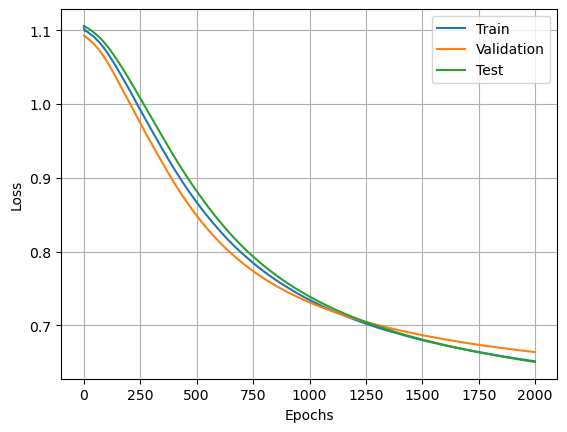

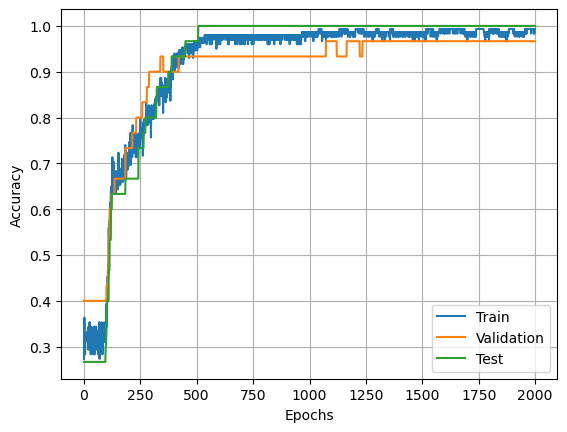

Train Loss:  0.6512789794802666
Validation Loss:  0.6637725836336613
Test Loss 0.6504490545392037
Train Accuracy:  0.9933333333333333
Validation Accuracy:  0.9666666666666667
Test Accuracy 1.0


In [7]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ann_model, train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy = train(ANN_Model(len(X[0]) , len(Y[0])).to(device), loss_fn, lr, epochs, train_loader, val_loader, test_loader)

# Make prediction

In [8]:
index = 50
scaler = StandardScaler()
scaler.fit(X_train)
x_index = X[index]
x_input = scaler.transform(np.array([x_index]))
x_input = torch.tensor(x_input, dtype = torch.float32)
x_input = x_input.to(device)
y_index = Y[index]
y_output = torch.tensor(y_index, dtype = torch.float32)
y_output = y_output.unsqueeze(0)
y_output = y_output.to(device)
ann_model.eval()
with torch.no_grad():
    prediction = ann_model(x_input)
    loss = loss_fn(prediction, y_output)
    prediction = torch.argmax(prediction, dim = 1)
    prediction = prediction.cpu().numpy()
    y_output = torch.argmax(y_output, dim = 1)
    y_output = y_output.cpu().numpy()
    accuracy = accuracy_score(y_output, prediction)
    
print("Features: ", x_index)
print("Features scale: ", x_input.tolist())
print("Target: ", OHE.categories_[0][int(y_output)])
print("Prediction: ", OHE.categories_[0][int(prediction)])
print("Accuracy: ", accuracy)
print("Loss: ", loss.item())

Features:  [7.  3.2 4.7 1.4]
Features scale:  [[1.3387799263000488, 0.3295912742614746, 0.4834531247615814, 0.2117188721895218]]
Target:  Iris-versicolor
Prediction:  Iris-versicolor
Accuracy:  1.0
Loss:  0.5524483919143677


# Save Model

In [9]:
torch.save(ann_model, "Multiclass_Classification_Model_Checkpoint.pt")